<a href="https://colab.research.google.com/github/oxygensend/COVID-19-predictions-ML/blob/master/BERDZIK_SZYMON_P1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analiza predykcji zachorowan i smiertelnosci COVID-19

In [1]:
pip install covid19dh


In [2]:
pip install countrygroups

In [3]:
from covid19dh import covid19
from collections import defaultdict

from sklearn.linear_model import LinearRegression
from sklearn.metrics import max_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import pandas.util.testing as tm


sns.mpl.rcParams['figure.figsize'] = (15.0, 9.0)


from countrygroups import EUROPEAN_UNION

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.


Jako dane globalne postanawiam użyć danych z krajow EU, poniewaz wyniki regresji dla danych globalnych nie wychodziły, poprzez roznorodnosc zbierania danych przez kraje oraz duze braki w danych. W krajach EU polityka covidowa byla prowadzona podobnie przez co bedzie mozna dokonac lepszej analizy.

In [136]:

glob, src = covid19(verbose=False)

In [5]:
glob = glob[glob['iso_alpha_3'].isin(EUROPEAN_UNION)]


# Pomocnicze funkcje

In [6]:
def unique(df):
  for col in df.columns:
    print(f'Unique values in {col} column: {len(df[col].unique())}')

In [7]:
def plot_scatter_normal_and_log(y, df):
  df_y = df.loc[:, ~df.columns.isin(['id', 'date', y])]


  figure, axis = plt.subplots(len(df_y.columns),2)
  i=0
  figure.set_size_inches(50,  15)
  for col in df_y:
  
    axis[i,0].scatter(df[y], df[col])
    axis[i,0].set_title(f"{y} vs {col} ")
    axis[i,1].scatter(np.log(df[y]), np.log(df[col]))
    axis[i,1].set_title(f"{y} vs {col} log scale")
    i+=1

  plt.show();

In [8]:
def print_stats(col, predicted, y_test):
  scores['r2'].append(r2_score( y_test.values.reshape(-1,1), predicted))
  scores['max_error'].append(max_error(y_test.values.reshape(-1,1), predicted))
  scores['rmse'].append(mean_squared_error( y_test.values.reshape(-1,1), predicted))


In [9]:
def plot_observed_and_residuals_vs_predicted():
  resid = predicted - y_test.values.reshape(-1,1)

  fig, ax = plt.subplots(1,2)


  sns.regplot(x=predicted, y=y_test, lowess=True, ax=ax[0],line_kws={'color': 'red'})
  ax[0].set_title('Observed vs. Predicted Values', fontsize=16)
  ax[0].set(xlabel='Predicted', ylabel='Observed')

  sns.regplot(x=predicted, y=resid, lowess=True, ax=ax[1],line_kws={'color': 'red'})
  ax[1].set_title('Residuals vs. Predicted Values', fontsize=16)
  ax[1].set(xlabel='Predicted', ylabel='Residuals');
  plt.show() 

In [77]:
def plot_date_observed_vs_predicted_confirmed(predicted):
  p = sns.lineplot(x=y_test.index, y=y_test)
  sns.lineplot(x=y_test.index, y=predicted.flatten())
  p.set(xlabel='Date', ylabel='Confirmed', title='Confirmed predicted and Observed vs date')
  p.legend(labels=['observed','predicted']);

In [76]:
def plot_date_observed_vs_predicted_deaths(predicted):
  p = sns.lineplot(x=y_test.index, y=y_test)
  sns.lineplot(x=y_test.index, y=predicted.flatten())
  p.set(xlabel='Date', ylabel='Deaths', title='Deaths predicted and Observed vs date')
  p.legend(labels=['observed','predicted']);

#Global data

# Eksploracja i czyszczenie danych


In [10]:
glob.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22529 entries, 115826 to 121500
Data columns (total 47 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   id                                   22529 non-null  object        
 1   date                                 22529 non-null  datetime64[ns]
 2   confirmed                            21727 non-null  float64       
 3   deaths                               21041 non-null  float64       
 4   recovered                            11083 non-null  float64       
 5   tests                                18000 non-null  float64       
 6   vaccines                             10836 non-null  float64       
 7   people_vaccinated                    10409 non-null  float64       
 8   people_fully_vaccinated              10362 non-null  float64       
 9   hosp                                 17637 non-null  float64       
 10  icu 

In [11]:
corr = glob.corr() 
corr.style.background_gradient(cmap='coolwarm')

/usr/local/lib/python3.7/dist-packages/pandas/io/formats/style.py:2813: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/usr/local/lib/python3.7/dist-packages/pandas/io/formats/style.py:2814: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


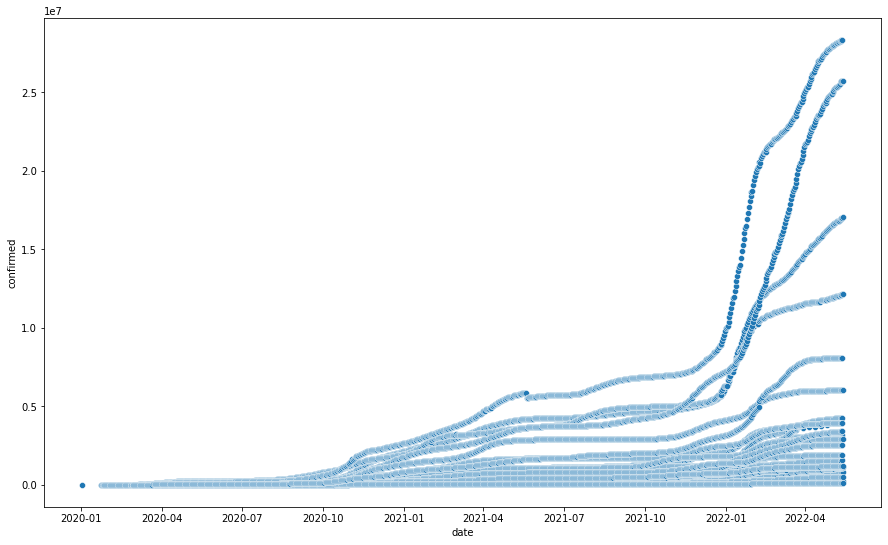

In [12]:
sns.scatterplot(glob['date'], glob['confirmed']);

Widzimy, ze nasze dane sa danymi kumulytawnymi, przez co analiza bylaby nie jasna, dlatego dane przeprocesingujemy ze wzgledu na przyrosty dzienne, aby otrzymac szereg czasowy.

In [13]:
unique(glob)

Unique values in id column: 27
Unique values in date column: 847
Unique values in confirmed column: 19847
Unique values in deaths column: 12337
Unique values in recovered column: 10470
Unique values in tests column: 17968
Unique values in vaccines column: 10539
Unique values in people_vaccinated column: 10060
Unique values in people_fully_vaccinated column: 9883
Unique values in hosp column: 6045
Unique values in icu column: 2657
Unique values in vent column: 569
Unique values in school_closing column: 8
Unique values in workplace_closing column: 8
Unique values in cancel_events column: 6
Unique values in gatherings_restrictions column: 10
Unique values in transport_closing column: 6
Unique values in stay_home_restrictions column: 7
Unique values in internal_movement_restrictions column: 6
Unique values in international_movement_restrictions column: 6
Unique values in information_campaigns column: 6
Unique values in testing_policy column: 5
Unique values in contact_tracing column: 4
Un

In [14]:
glob['school_closing'].unique()

array([-3.,  3., -2.,  1.,  2., nan,  0., -1.])

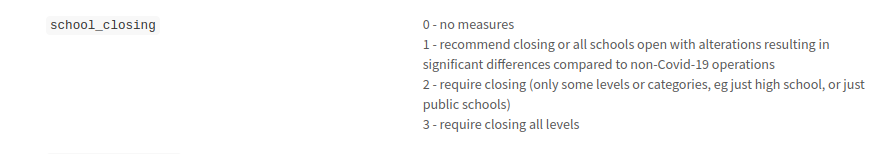



Wedlug dokumentacji zmienna school_closing posiada 4 unikalne wartosci, wnioskue, że wartosci ujemne są błedne i odpowiadają wartosci bezwzglednej tych zmiennych

In [137]:
glob['school_closing'] = abs(glob['school_closing'])

Rodzielmy date na 3 kolumny

In [138]:
glob['month'] = pd.DatetimeIndex(glob['date']).month
glob['year'] = pd.DatetimeIndex(glob['date']).year
glob['day'] = pd.DatetimeIndex(glob['date']).day



## Wybór lokalnych danych wybrany kraj - Szwecja

In [139]:

local = glob[glob['iso_alpha_3'] == 'SWE']

In [18]:
glob

id       date  confirmed   deaths  recovered       tests  \
115826  03dcf038 2020-02-24      229.0      7.0        1.0      4324.0   
115827  03dcf038 2020-02-25      322.0     10.0        1.0      8623.0   
115828  03dcf038 2020-02-26      400.0     12.0        3.0      9587.0   
115829  03dcf038 2020-02-27      650.0     17.0       45.0     12014.0   
115830  03dcf038 2020-02-28      888.0     21.0       46.0     15695.0   
...          ...        ...        ...      ...        ...         ...   
121496  f4e28a6b 2022-05-09  8061432.0  22278.0        NaN  30585239.0   
121497  f4e28a6b 2022-05-10  8063012.0  22281.0        NaN         NaN   
121498  f4e28a6b 2022-05-11  8064412.0  22288.0        NaN         NaN   
121499  f4e28a6b 2022-05-12  8065843.0  22292.0        NaN         NaN   
121500  f4e28a6b 2022-05-13  8067116.0  22292.0        NaN         NaN   

        vaccines  people_vaccinated  people_fully_vaccinated   hosp  ...  \
115826       NaN                NaN                      NaN  127.0  ...   
115827       NaN                NaN                      NaN  150.0  ...   
115828       NaN                NaN                      NaN  164.0  ...   
115829       NaN                NaN                      NaN  304.0  ...   
115830       NaN                NaN                      NaN  409.0  ...   
...          ...                ...                      ...    ...  ...   
121496       NaN                NaN                      NaN  602.0  ...   
121497       NaN                NaN                      NaN  620.0  ...   
121498       NaN                NaN                      NaN  609.0  ...   
121499       NaN                NaN                      NaN  558.0  ...   
121500       NaN                NaN                      NaN  515.0  ...   

        iso_currency  key_local          key_google_mobility  \
115826           EUR        NaN  ChIJA9KNRIL-1BIRb15jJFz1LOI   
115827           EUR        NaN  ChIJA9KNRIL-1BIRb15jJFz1LOI   
115828           EUR        NaN  ChIJA9KNRIL-1BIRb15jJFz1LOI   
115829           EUR        NaN  ChIJA9KNRIL-1BIRb15jJFz1LOI   
115830           EUR        NaN  ChIJA9KNRIL-1BIRb15jJFz1LOI   
...              ...        ...                          ...   
121496           EUR        NaN  ChIJu-SH28MJxkcRnwq9_851obM   
121497           EUR        NaN  ChIJu-SH28MJxkcRnwq9_851obM   
121498           EUR        NaN  ChIJu-SH28MJxkcRnwq9_851obM   
121499           EUR        NaN  ChIJu-SH28MJxkcRnwq9_851obM   
121500           EUR        NaN  ChIJu-SH28MJxkcRnwq9_851obM   

        key_apple_mobility  key_jhu_csse  key_nuts  key_gadm  month  year  day  
115826               Italy            IT       NaN       ITA      2  2020   24  
115827               Italy            IT       NaN       ITA      2  2020   25  
115828               Italy            IT       NaN       ITA      2  2020   26  
115829               Italy            IT       NaN       ITA      2  2020   27  
115830               Italy            IT       NaN       ITA      2  2020   28  
...                    ...           ...       ...       ...    ...   ...  ...  
121496         Netherlands            NL       NaN       NLD      5  2022    9  
121497         Netherlands            NL       NaN       NLD      5  2022   10  
121498         Netherlands            NL       NaN       NLD      5  2022   11  
121499         Netherlands            NL       NaN       NLD      5  2022   12  
121500         Netherlands            NL       NaN       NLD      5  2022   13  

[22529 rows x 50 columns]

Wstępne pozbycie się niepotrzebnych kolumn do dalszej analizy

In [19]:
glob = glob[glob.columns.drop(list(glob.filter(regex='administrative.*')))]
glob = glob.drop('id', axis=1)
countries = glob['iso_alpha_3']
dates = glob.iloc[:,-3:]
glob = glob.iloc[:,:17]
glob=pd.merge(glob, dates, left_index=True, right_index=True)
glob['countries'] = countries
glob=glob.drop('vent', axis=1)

In [20]:
glob.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22529 entries, 115826 to 121500
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   date                     22529 non-null  datetime64[ns]
 1   confirmed                21727 non-null  float64       
 2   deaths                   21041 non-null  float64       
 3   recovered                11083 non-null  float64       
 4   tests                    18000 non-null  float64       
 5   vaccines                 10836 non-null  float64       
 6   people_vaccinated        10409 non-null  float64       
 7   people_fully_vaccinated  10362 non-null  float64       
 8   hosp                     17637 non-null  float64       
 9   icu                      15271 non-null  float64       
 10  school_closing           22261 non-null  float64       
 11  workplace_closing        22261 non-null  float64       
 12  cancel_events            2

In [21]:
glob.isnull().mean()

date                       0.000000
confirmed                  0.035599
deaths                     0.066048
recovered                  0.508056
tests                      0.201030
vaccines                   0.519020
people_vaccinated          0.537973
people_fully_vaccinated    0.540059
hosp                       0.217142
icu                        0.322163
school_closing             0.011896
workplace_closing          0.011896
cancel_events              0.011896
gatherings_restrictions    0.012162
transport_closing          0.012162
stay_home_restrictions     0.012162
month                      0.000000
year                       0.000000
day                        0.000000
countries                  0.000000
dtype: float64

Możemy zaobserowawać bardzo duże braki w danych. Zmienną `vent` postanawiam usunąć, ponieważ nie wnosi ona zbyt wiele do naszego modelu.
Zmienne `school_closing`, `workplace_closing`, `cancel_events`, `gatherings_restrictions`, `transport_closing`, `stay_home_restrictions`, poniewaz są to zmienne kategoryczne, a nie chce się ich na tą chwile pozbywac zastąpie najczęsciej występująca wartoscia.

Dużą role w brakach w zmiennych `vaccines` `people_vaccinated` `people_fully_vaccinated` odgrywa to, że pierwsze szczepienia pojawiły się jakoś w grudniu 2020 roku oraz to, że niektóre państwa raportowały to np. co tydzien. Dlatego wartosci NaN zamienie na odpowiednio na 0 oraz ostatnią występująca wartość w danym kraju.

Zmienne `hosp` i  `icu` nie sa zmiennymi kumulytawnymi, dlatego braki wypelnie zerami.

Zmienne `confirmed`, `deaths`, `tests`, `recovered` wypelnie tak samo jak w przypadku szczepionek ostatnia wartoscia w danym kraju nie bedaca NaN oraz zerami, aby nie zaburzyc dalszej analizy.

In [22]:
glob

date  confirmed   deaths  recovered       tests  vaccines  \
115826 2020-02-24      229.0      7.0        1.0      4324.0       NaN   
115827 2020-02-25      322.0     10.0        1.0      8623.0       NaN   
115828 2020-02-26      400.0     12.0        3.0      9587.0       NaN   
115829 2020-02-27      650.0     17.0       45.0     12014.0       NaN   
115830 2020-02-28      888.0     21.0       46.0     15695.0       NaN   
...           ...        ...      ...        ...         ...       ...   
121496 2022-05-09  8061432.0  22278.0        NaN  30585239.0       NaN   
121497 2022-05-10  8063012.0  22281.0        NaN         NaN       NaN   
121498 2022-05-11  8064412.0  22288.0        NaN         NaN       NaN   
121499 2022-05-12  8065843.0  22292.0        NaN         NaN       NaN   
121500 2022-05-13  8067116.0  22292.0        NaN         NaN       NaN   

        people_vaccinated  people_fully_vaccinated   hosp   icu  \
115826                NaN                      NaN  127.0  26.0   
115827                NaN                      NaN  150.0  35.0   
115828                NaN                      NaN  164.0  36.0   
115829                NaN                      NaN  304.0  56.0   
115830                NaN                      NaN  409.0  64.0   
...                   ...                      ...    ...   ...   
121496                NaN                      NaN  602.0  40.0   
121497                NaN                      NaN  620.0  39.0   
121498                NaN                      NaN  609.0  42.0   
121499                NaN                      NaN  558.0  42.0   
121500                NaN                      NaN  515.0  40.0   

        school_closing  workplace_closing  cancel_events  \
115826             3.0               -3.0           -2.0   
115827             3.0               -3.0           -2.0   
115828             3.0               -3.0           -2.0   
115829             3.0               -3.0           -2.0   
115830             3.0               -3.0           -2.0   
...                ...                ...            ...   
121496             NaN                NaN            NaN   
121497             NaN                NaN            NaN   
121498             NaN                NaN            NaN   
121499             NaN                NaN            NaN   
121500             NaN                NaN            NaN   

        gatherings_restrictions  transport_closing  stay_home_restrictions  \
115826                     -4.0                0.0                    -2.0   
115827                     -4.0                0.0                    -2.0   
115828                     -4.0                0.0                    -2.0   
115829                     -4.0                0.0                    -2.0   
115830                     -4.0                0.0                    -2.0   
...                         ...                ...                     ...   
121496                      NaN                NaN                     NaN   
121497                      NaN                NaN                     NaN   
121498                      NaN                NaN                     NaN   
121499                      NaN                NaN                     NaN   
121500                      NaN                NaN                     NaN   

        month  year  day countries  
115826      2  2020   24       ITA  
115827      2  2020   25       ITA  
115828      2  2020   26       ITA  
115829      2  2020   27       ITA  
115830      2  2020   28       ITA  
...       ...   ...  ...       ...  
121496      5  2022    9       NLD  
121497      5  2022   10       NLD  
121498      5  2022   11       NLD  
121499      5  2022   12       NLD  
121500      5  2022   13       NLD  

[22529 rows x 20 columns]

Mapowanie oraz czyszczenie kolumn kategorycznych

In [23]:

col_to_replace = [ 'school_closing', 'workplace_closing', 'cancel_events', 'gatherings_restrictions', 'transport_closing', 'stay_home_restrictions']


for col in col_to_replace:
  glob[col].fillna(glob[col].mode().iloc[0], inplace=True)
  glob[col] = glob[col].map({v:i for i, v in enumerate(glob[col])})


glob[col_to_replace]=glob[col_to_replace].astype('int') 

for col in ['month', 'year', 'day']:
  glob[col] = glob[col].map({v:i for i, v in enumerate(glob[col])})
  




Czyszczenie zmiennych kumulatywnych

In [24]:
glob_agg = pd.DataFrame()
countries = glob['countries'].unique()
cols_to_fill = ['deaths','confirmed','recovered', 'tests', 'vaccines','people_vaccinated', 'people_fully_vaccinated']


for country in countries:
  
  condition = glob['countries'] == country
  glob.loc[condition, cols_to_fill]=glob.loc[condition, cols_to_fill].fillna(method='ffill')
  glob.loc[condition, cols_to_fill]=glob.loc[condition, cols_to_fill].fillna(0)



In [25]:
glob['hosp'].fillna(0, inplace=True)
glob['icu'].fillna(0, inplace=True)

In [26]:
glob.isna().mean()

date                       0.0
confirmed                  0.0
deaths                     0.0
recovered                  0.0
tests                      0.0
vaccines                   0.0
people_vaccinated          0.0
people_fully_vaccinated    0.0
hosp                       0.0
icu                        0.0
school_closing             0.0
workplace_closing          0.0
cancel_events              0.0
gatherings_restrictions    0.0
transport_closing          0.0
stay_home_restrictions     0.0
month                      0.0
year                       0.0
day                        0.0
countries                  0.0
dtype: float64

Jak widzimy pozbylismy sie wartosci NaN nie tracac przy tym danych

In [27]:
glob.shape

(22529, 20)

In [28]:
glob.set_index('date', inplace=True)

Do dalszej analizy potrzebujemy danych zagregowanych, w tym celu obliczmy przyrosty dzienne dla kolumn, ktore tego potrzebuja oraz policzmy mode dla zmiennych kategorycznych.

In [50]:
col_to_count_diff = ['confirmed', 'deaths',	'recovered'	,'tests'	,'vaccines',	'people_vaccinated',	'people_fully_vaccinated',	 'countries']
col_categorical = ['school_closing',	'workplace_closing',	'cancel_events',	'gatherings_restrictions',	'transport_closing',	'stay_home_restrictions',	'month'	,'year',	'day']

categorical_var = glob[col_categorical].groupby('date').agg( lambda x: np.random.choice(x.mode()))
hosp_ic = glob[['hosp', 'icu']].groupby('date').sum()
glob_agg = glob[col_to_count_diff].groupby('countries').diff()
glob_agg = glob_agg.groupby('date').sum()
glob_agg = pd.merge(glob_agg, hosp_ic, right_index=True, left_index=True)
glob_agg = pd.merge(glob_agg, categorical_var, right_index=True, left_index=True)

glob_agg

confirmed  deaths  recovered      tests  vaccines  \
date                                                            
2020-01-02        0.0     0.0        0.0        0.0       0.0   
2020-01-06        0.0     0.0        0.0        0.0       0.0   
2020-01-18        0.0     0.0        0.0        0.0       0.0   
2020-01-22        0.0     0.0        0.0        0.0       0.0   
2020-01-23        1.0     0.0        1.0        0.0       0.0   
...               ...     ...        ...        ...       ...   
2022-05-10   378859.0   821.0    84381.0   931703.0  179941.0   
2022-05-11   188166.0   412.0    91228.0  1204300.0  258073.0   
2022-05-12   174341.0   450.0    70368.0   438187.0  329274.0   
2022-05-13   198190.0   663.0    58272.0   391987.0   80066.0   
2022-05-14    41199.0   131.0    44039.0   266248.0    7769.0   

            people_vaccinated  people_fully_vaccinated     hosp     icu  \
date                                                                      
2020-01-02                0.0                      0.0      0.0     0.0   
2020-01-06                0.0                      0.0      1.0     0.0   
2020-01-18                0.0                      0.0      1.0     0.0   
2020-01-22                0.0                      0.0      0.0     0.0   
2020-01-23                0.0                      0.0      0.0     0.0   
...                       ...                      ...      ...     ...   
2022-05-10             7169.0                  11177.0  35890.0  3194.0   
2022-05-11            15543.0                  33536.0  33840.0  3040.0   
2022-05-12             7319.0                  12074.0  33003.0  2949.0   
2022-05-13             2755.0                   5997.0  29403.0  2720.0   
2022-05-14              662.0                   1162.0   8226.0   366.0   

            school_closing  workplace_closing  cancel_events  \
date                                                           
2020-01-02           22522              22522          22522   
2020-01-06           22522              22522          22522   
2020-01-18           22522              22522          22522   
2020-01-22           22522              22522          22522   
2020-01-23           22522              22522          22522   
...                    ...                ...            ...   
2022-05-10           22528              22528          22528   
2022-05-11           22528              22528          22528   
2022-05-12           22528              22528          22528   
2022-05-13           22528              22528          22528   
2022-05-14           22528              22528          22528   

            gatherings_restrictions  transport_closing  \
date                                                     
2020-01-02                    22522              22528   
2020-01-06                    22522              22528   
2020-01-18                    22522              22528   
2020-01-22                    22522              22528   
2020-01-23                    22522              22528   
...                             ...                ...   
2022-05-10                    22528              22528   
2022-05-11                    22528              22528   
2022-05-12                    22528              22528   
2022-05-13                    22528              22528   
2022-05-14                    22528              22528   

            stay_home_restrictions  month   year    day  
date                                                     
2020-01-02                   22528  22426  22030  22517  
2020-01-06                   22528  22426  22030  22521  
2020-01-18                   22528  22426  22030  22503  
2020-01-22                   22528  22426  22030  22507  
2020-01-23                   22528  22426  22030  22508  
...                            ...    ...    ...    ...  
2022-05-10                   22528  22528  22528  22525  
2022-05-11                   22528  22528  22528  22526  
2022-05-12            

Mozna zauwazyc, ze przyrosty w pierwszych wierszach w ogole sie nie zmienialy. Pandemia w Europie zaczela sie w marcu, dlatego zshiftujmy dane o ~30 dni aby nie zaburzac modeli.

In [51]:
glob_agg = glob_agg[35:-1]
glob_agg

confirmed  deaths  recovered      tests  vaccines  \
date                                                            
2020-02-23        1.0     0.0        0.0        3.0       0.0   
2020-02-24        1.0     0.0        1.0       14.0       0.0   
2020-02-25      102.0     3.0       10.0     4331.0       0.0   
2020-02-26      100.0     2.0        9.0     1027.0       0.0   
2020-02-27      303.0     5.0       66.0     2591.0       0.0   
...               ...     ...        ...        ...       ...   
2022-05-09   125766.0   367.0    41828.0   765460.0   99926.0   
2022-05-10   378859.0   821.0    84381.0   931703.0  179941.0   
2022-05-11   188166.0   412.0    91228.0  1204300.0  258073.0   
2022-05-12   174341.0   450.0    70368.0   438187.0  329274.0   
2022-05-13   198190.0   663.0    58272.0   391987.0   80066.0   

            people_vaccinated  people_fully_vaccinated     hosp     icu  \
date                                                                      
2020-02-23                0.0                      0.0      0.0     0.0   
2020-02-24                0.0                      0.0    127.0    26.0   
2020-02-25                0.0                      0.0    151.0    35.0   
2020-02-26                0.0                      0.0    165.0    36.0   
2020-02-27                0.0                      0.0    307.0    63.0   
...                       ...                      ...      ...     ...   
2022-05-09             4446.0                   6773.0  35424.0  3196.0   
2022-05-10             7169.0                  11177.0  35890.0  3194.0   
2022-05-11            15543.0                  33536.0  33840.0  3040.0   
2022-05-12             7319.0                  12074.0  33003.0  2949.0   
2022-05-13             2755.0                   5997.0  29403.0  2720.0   

            school_closing  workplace_closing  cancel_events  \
date                                                           
2020-02-23           22522              22522          22522   
2020-02-24           22522              22522          22522   
2020-02-25           22522              22522          22522   
2020-02-26           22522              22522          22522   
2020-02-27           22522              22522          22522   
...                    ...                ...            ...   
2022-05-09           22528              22528          22522   
2022-05-10           22528              22528          22528   
2022-05-11           22528              22528          22528   
2022-05-12           22528              22528          22528   
2022-05-13           22528              22528          22528   

            gatherings_restrictions  transport_closing  \
date                                                     
2020-02-23                    22522              22528   
2020-02-24                    22522              22528   
2020-02-25                    22522              22528   
2020-02-26                    22522              22528   
2020-02-27                    22522              22528   
...                             ...                ...   
2022-05-09                    22522              22528   
2022-05-10                    22528              22528   
2022-05-11                    22528              22528   
2022-05-12                    22528              22528   
2022-05-13                    22528              22528   

            stay_home_restrictions  month   year    day  
date                                                     
2020-02-23                   22528  22454  22030  22508  
2020-02-24                   22528  22454  22030  22509  
2020-02-25                   22528  22454  22030  22510  
2020-02-26                   22528  22454  22030  22511  
2020-02-27                   22528  22454  22030  22512  
...                            ...    ...    ...    ...  
2022-05-09                   22528  22528  22528  22524  
2022-05-10                   22528  22528  22528  22525  
2022-05-11            

In [52]:
glob_agg.shape

(811, 18)

Zobaczmy rozklady zmiennych

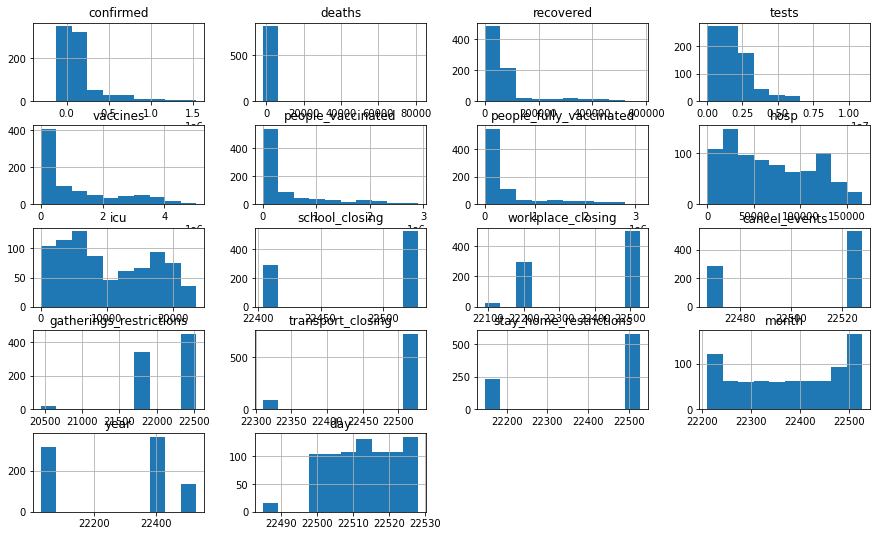

In [53]:
glob_agg.hist();


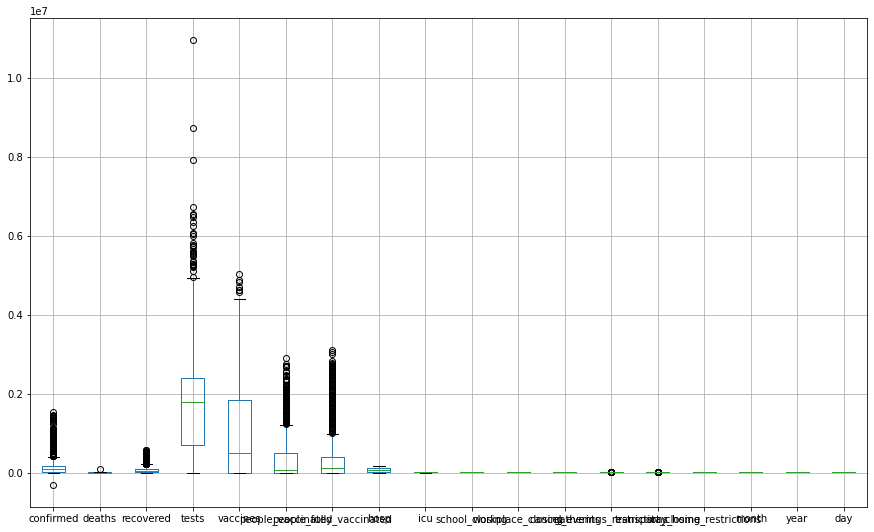

In [54]:
glob_agg.boxplot();

W zmienych deaths oraz confirmed mozna zaobserwowac pojedyncze wartosci odstajace, najlepiej sie ich pozbyc.

In [55]:
max = glob_agg['deaths'].max()
glob_agg = glob_agg[(glob_agg['deaths'] < max) & (glob_agg['confirmed'] > 0) & (glob_agg['deaths'] > 0)]

Narysujmy sobie  wykresy zmiennych `confirmed` i `deaths` vs inne w dwoch skalach oraz rozklady normalne zmiennych

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


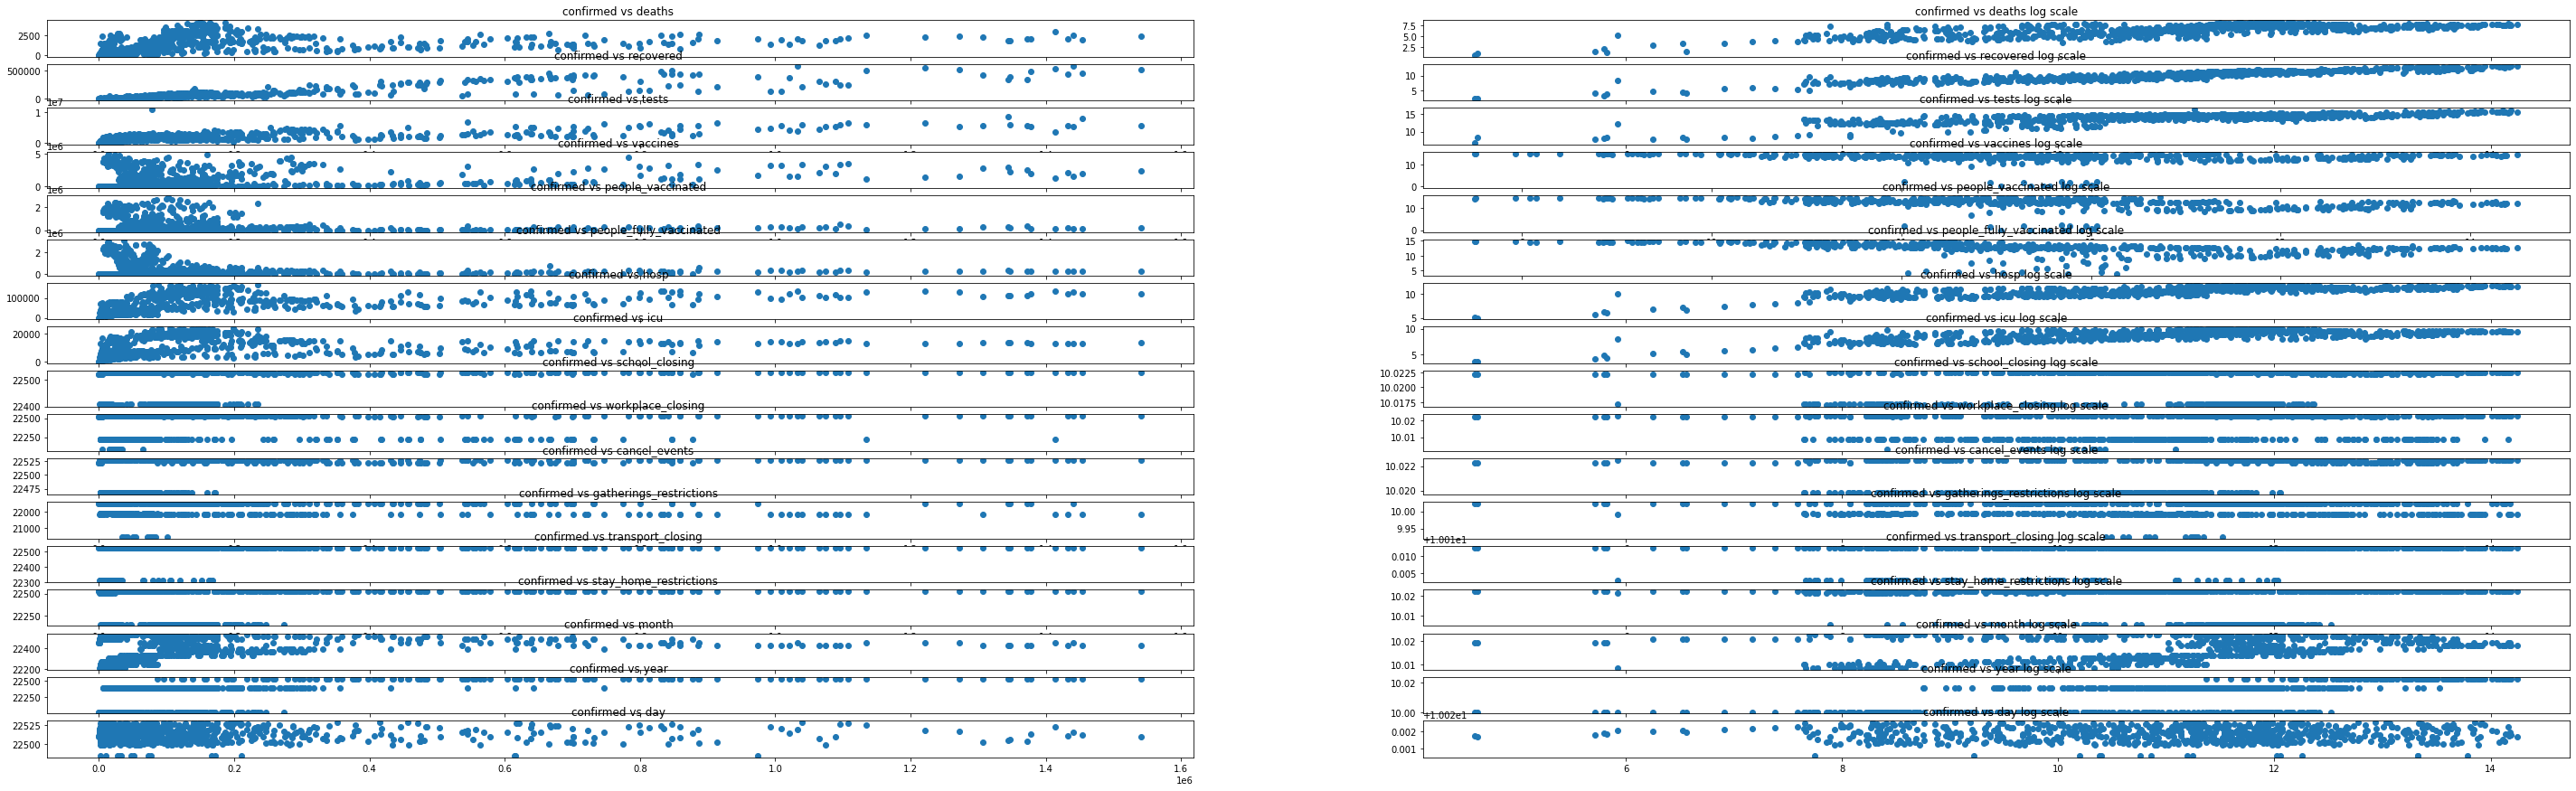

In [35]:
plot_scatter_normal_and_log('confirmed', glob_agg)

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


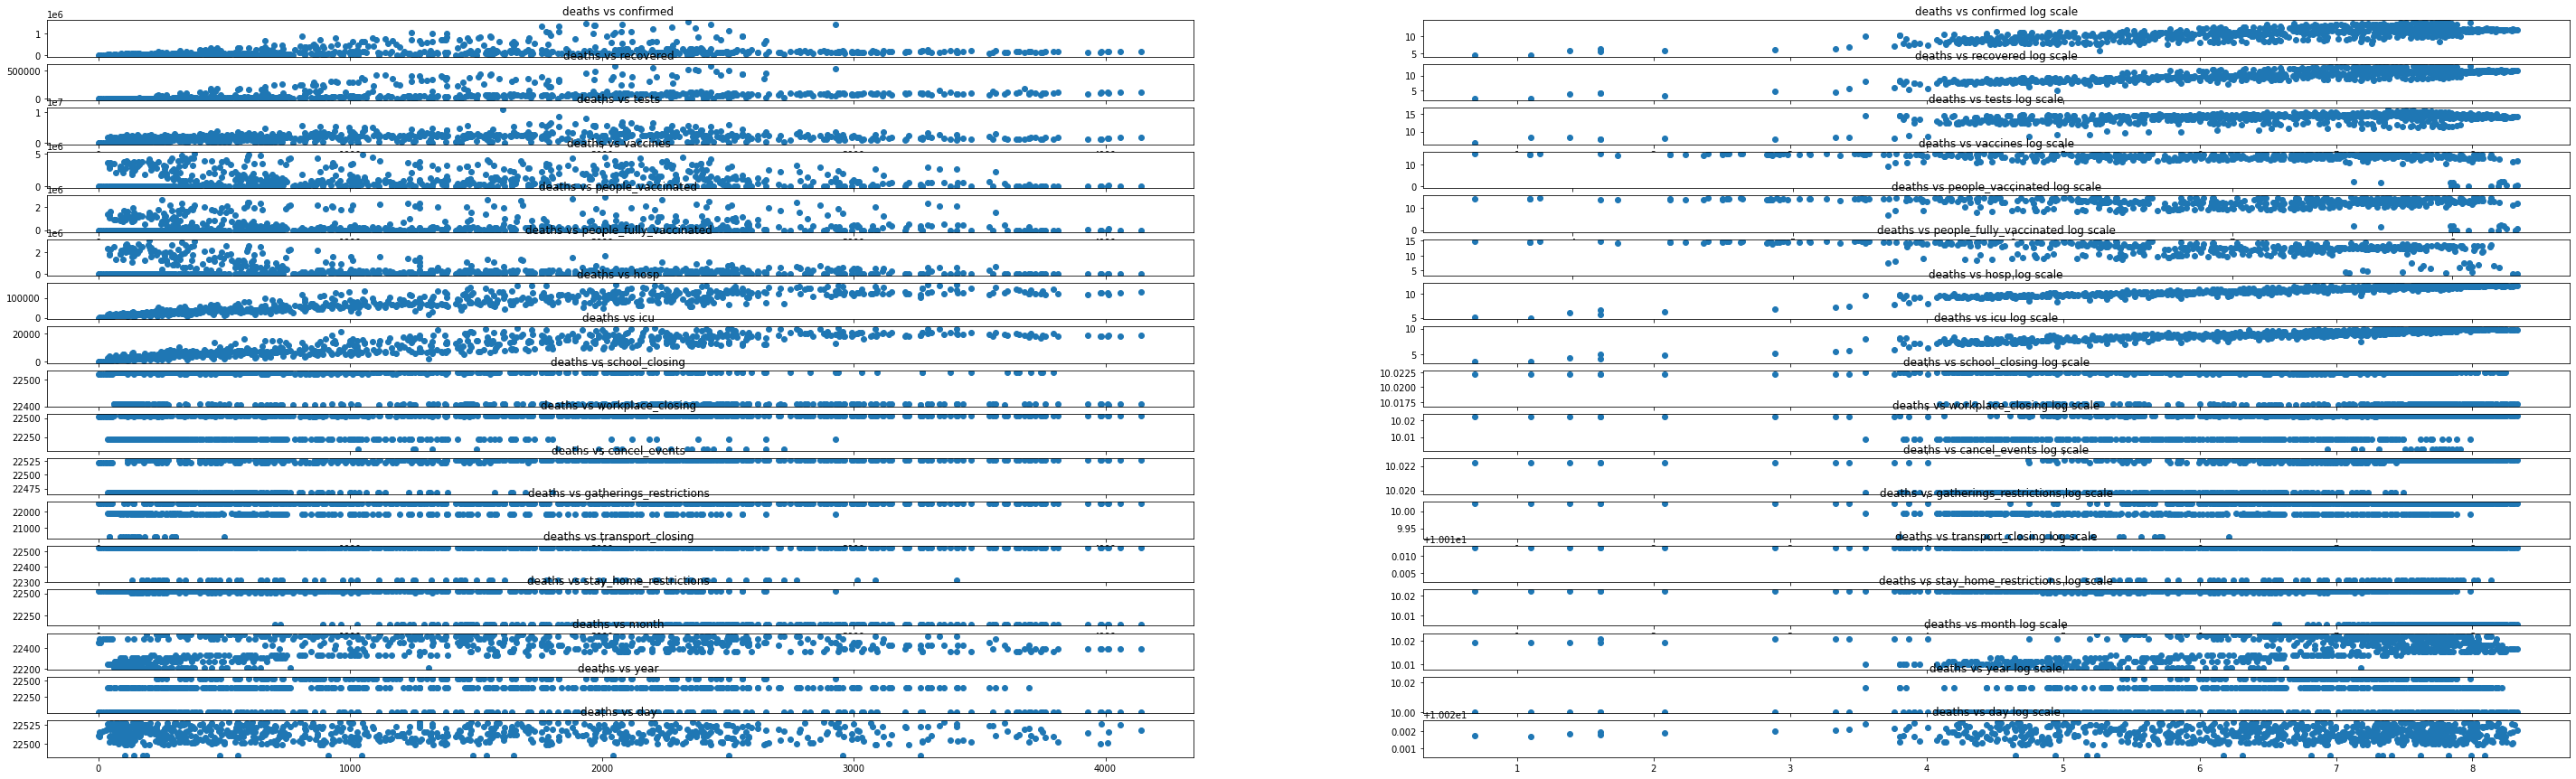

In [36]:
plot_scatter_normal_and_log('deaths', glob_agg)

Zmienne ukladaja sie w podobny sposob zarowno w dwoch transformacjach, dlatego nie bedziemy modyfikowac naszych danych do dalszej analizy.

In [37]:
corr = glob_agg.corr()
corr.style.background_gradient(cmap='coolwarm')

Patrzac na macierz korelacji, nie ma zbyt wielkiego szalu dlatego modelach regresji liniowej przetestuje kazdą zmienna ilosciowa.

Ustandaryzujmy dane przed dalszą pracą

In [56]:
sc = StandardScaler()

agg_columns = glob_agg.columns
agg_index = glob_agg.index
scaled_agg = sc.fit_transform(glob_agg.values)
glob_agg = pd.DataFrame(scaled_agg, columns=agg_columns, index=agg_index)

# Tworzenie modeli

# Model regresji linowej

## Predykcja zachorowań

In [57]:
col_name = ['deaths', 'vaccines', 'tests',  'recovered',  'icu', 'hosp','people_fully_vaccinated', 'people_vaccinated']

X_train, X_test, y_train, y_test = train_test_split(glob_agg[col_name], glob_agg['confirmed'], test_size=0.30, random_state=0)



In [59]:
reg = LinearRegression()
scores = defaultdict(list)
for col in col_name:



  reg.fit(X_train[col].values.reshape(-1,1), y_train.values.reshape(-1,1))
  predicted = reg.predict(X_test[col].values.reshape(-1,1))
  print_stats(col, predicted, y_test)

scored_global_confirmed = pd.DataFrame(scores, index=col_name).sort_values("r2", ascending=0)

scored_global_confirmed

r2  max_error      rmse
recovered                0.780848   2.475166  0.182137
tests                    0.292613   5.407828  0.587908
hosp                     0.138326   4.200224  0.716136
deaths                   0.066462   4.392533  0.775862
people_fully_vaccinated  0.030356   4.751852  0.805869
people_vaccinated        0.026057   4.725124  0.809442
icu                      0.022027   4.688820  0.812791
vaccines                -0.025523   4.760815  0.852311

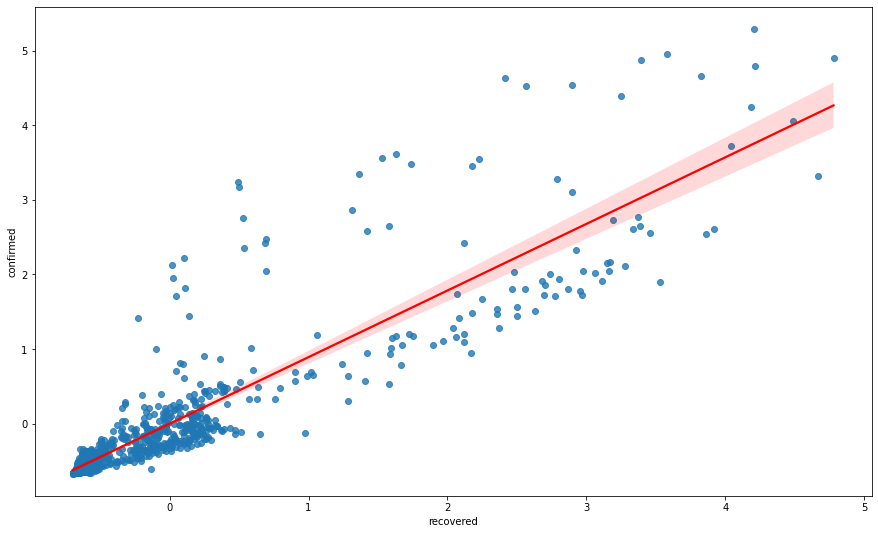

In [60]:
sns.regplot(x=glob_agg['recovered'], y=glob_agg['confirmed'], line_kws={'color': 'red'});  

Mozna zauwazyc liniowosc

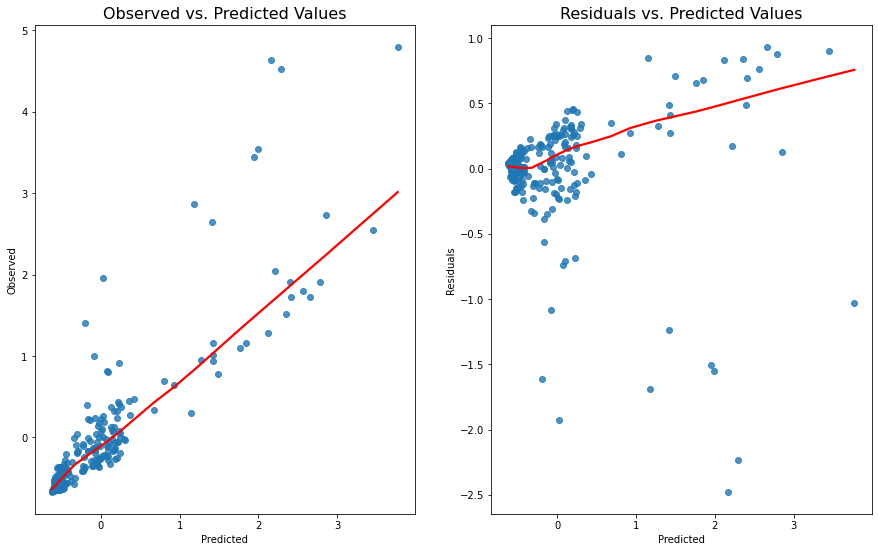

In [61]:
X_train, X_test, y_train, y_test = train_test_split(glob_agg['recovered'], glob_agg['confirmed'], test_size=0.30, random_state=0)

reg = LinearRegression().fit(X_train.values.reshape(-1,1), y_train.values.reshape(-1,1))

predicted = reg.predict(X_test.values.reshape(-1,1))
resid = predicted - y_test.values.reshape(-1,1)

plot_observed_and_residuals_vs_predicted()

brak homoscedystycznosci - prawy wykres waraiancja powinna oscylowac dookola 0, a z naszego wytkresu mozna odczytac, ze dla wiekszych wartosci nasz model dziala coraz gorzej



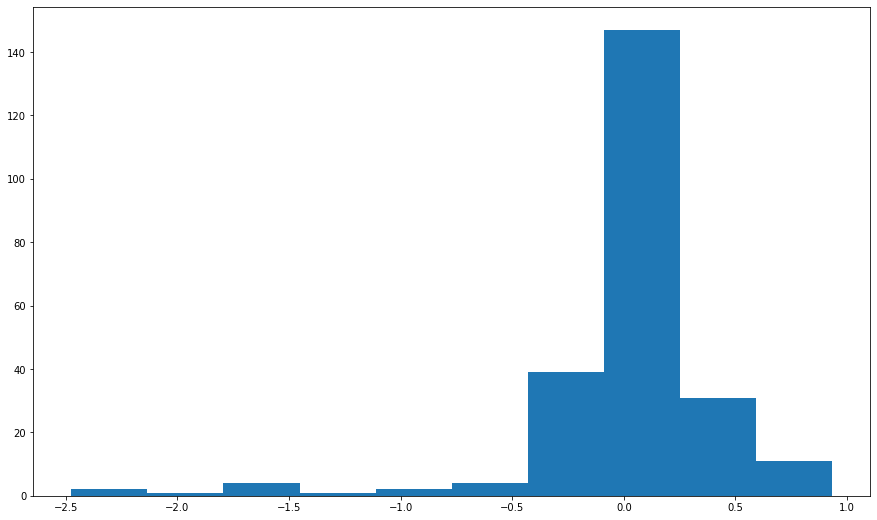

In [62]:
plt.hist(resid);

Brak rozkladu normalnego

Warunki regresji liniowej nie sa spelnione

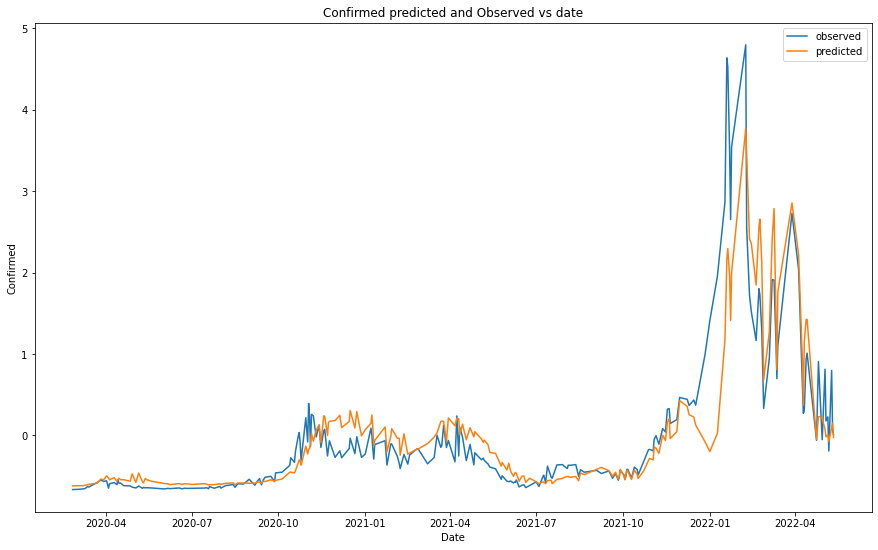

In [78]:
plot_date_observed_vs_predicted_confirmed(predicted);

## Predykcja zgonów

In [80]:
col_name = ['confirmed', 'vaccines', 'icu', 'hosp', 'recovered','tests', 'people_fully_vaccinated', 'people_vaccinated']

X_train, X_test, y_train, y_test = train_test_split(glob_agg[col_name], glob_agg['deaths'], test_size=0.30, random_state=0)

In [81]:
reg = LinearRegression()
scores = defaultdict(list)
for col in col_name:



  reg.fit(X_train[col].values.reshape(-1,1), y_train.values.reshape(-1,1))
  predicted = reg.predict(X_test[col].values.reshape(-1,1))
  print_stats(col, predicted, y_test)

scored_global_confirmed = pd.DataFrame(scores, index=col_name).sort_values("r2", ascending=0)

scored_global_confirmed

r2  max_error      rmse
hosp                     0.775642   1.532425  0.218774
icu                      0.765235   1.654304  0.228922
recovered                0.134187   2.567845  0.844264
confirmed                0.073597   2.688889  0.903346
people_fully_vaccinated  0.066957   2.519745  0.909820
tests                    0.037878   2.771840  0.938175
people_vaccinated       -0.005443   2.690624  0.980418
vaccines                -0.007992   2.692655  0.982904

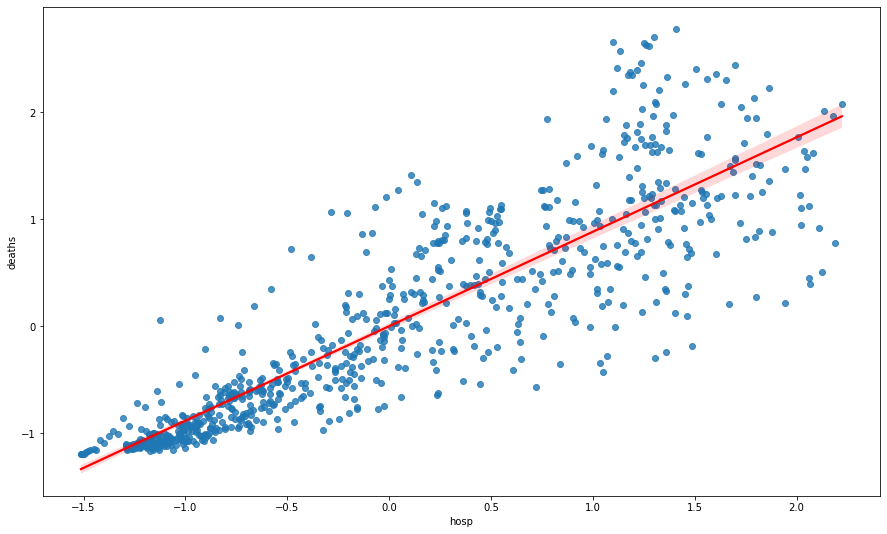

In [82]:
sns.regplot(x=glob_agg['hosp'], y=glob_agg['deaths'], line_kws={'color': 'red'});  

Liniowosc wystepuje

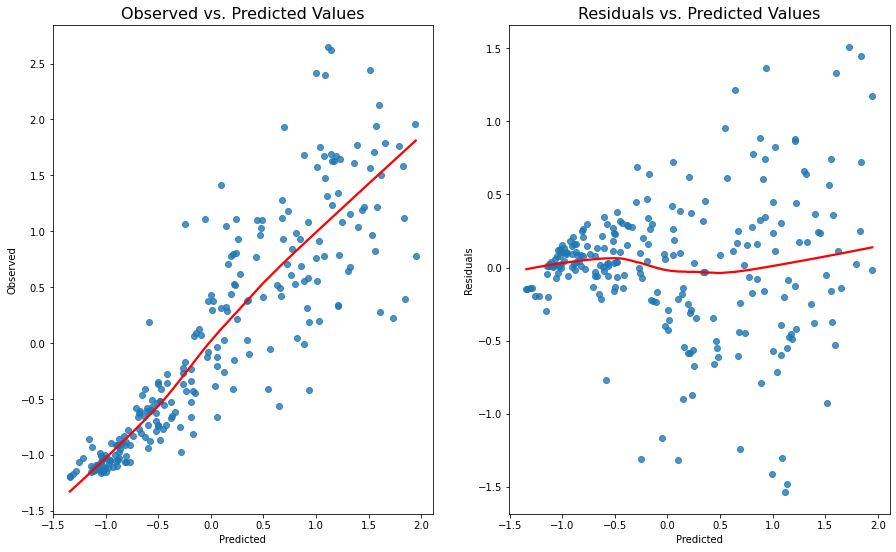

In [83]:
X_train, X_test, y_train, y_test = train_test_split(glob_agg['hosp'], glob_agg['deaths'], test_size=0.30, random_state=0)

reg = LinearRegression().fit(X_train.values.reshape(-1,1), y_train.values.reshape(-1,1))

predicted = reg.predict(X_test.values.reshape(-1,1))
resid = predicted - y_test.values.reshape(-1,1)

plot_observed_and_residuals_vs_predicted()

Warjanca oscyluje dookola zera, homoskedastycznosc wystepuje

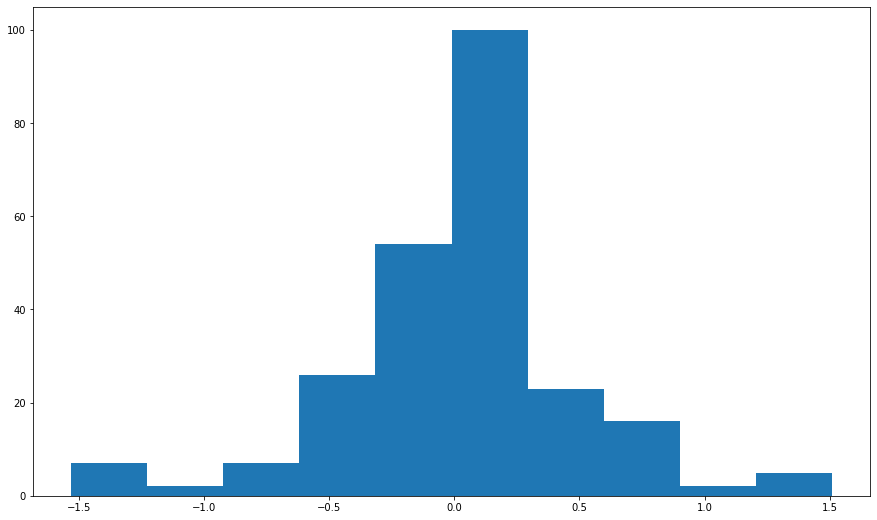

In [84]:
plt.hist(resid);

Resiuda posiadaja rozklad normalny

**Warunki regresji liniowej sa spelnione**


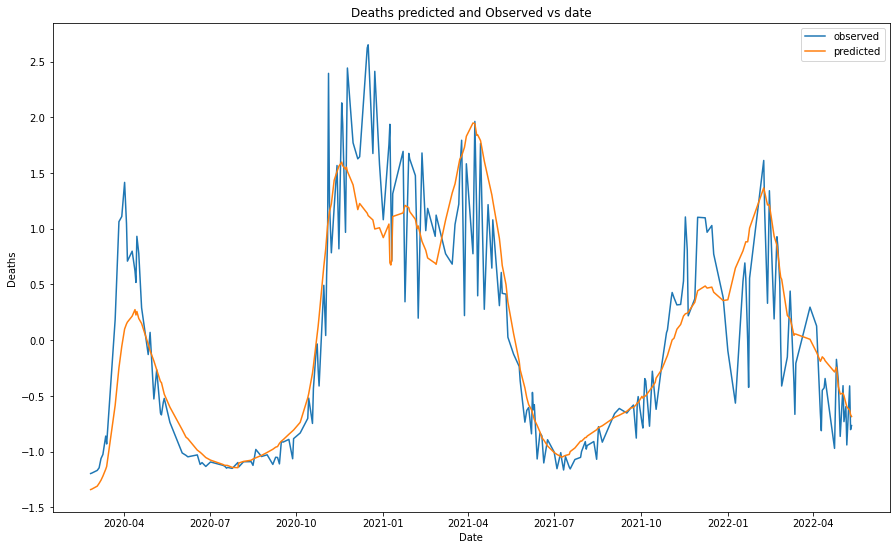

In [85]:
plot_date_observed_vs_predicted_deaths(predicted);

## Modele regresji wielorakiej

Spójrzmy jeszcze raz na macierz korelacji

In [ ]:
corr = glob_agg.corr()
corr.style.background_gradient(cmap='coolwarm')

## Model 1 - predykcja zachorowań</br>


Ciezko znalezc dla naszego modelu zmienne opisujace nie posiadajace korelacji pomiedzy soba. </br>
Dla tego modelu wybiore: recovered, tests,stay_home_restriction

In [86]:
col_name = ['recovered', 'tests', 'stay_home_restrictions']
X_train, X_test, y_train, y_test = train_test_split(glob_agg[col_name], glob_agg['confirmed'], test_size=0.30, random_state=0)

In [87]:
reg = LinearRegression()  
scores = defaultdict(list)

reg.fit(X_train, y_train.values.reshape(-1,1))

predicted = reg.predict(X_test)

print_stats(col_name, predicted, y_test)

In [88]:
scores_model_1 = pd.DataFrame(scores)

scores_model_1

r2  max_error      rmse
0  0.812928   2.207411  0.155475

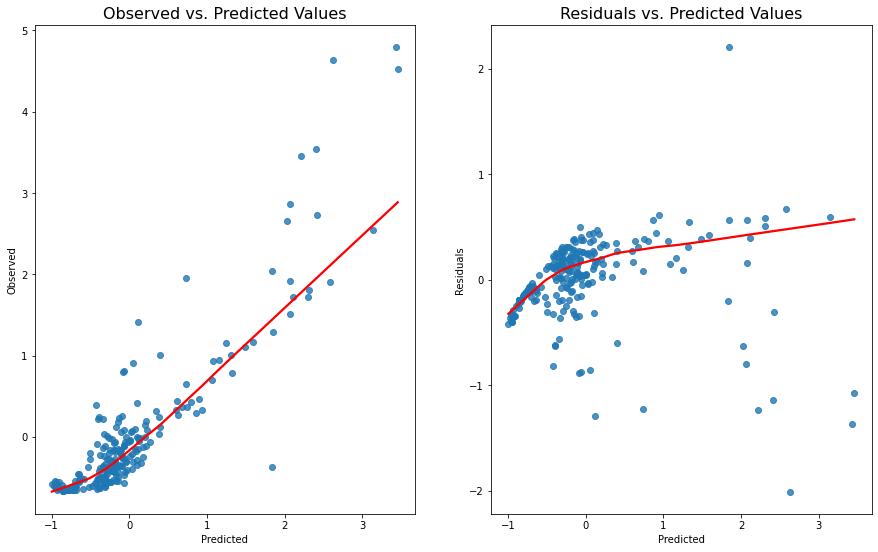

In [89]:
plot_observed_and_residuals_vs_predicted()

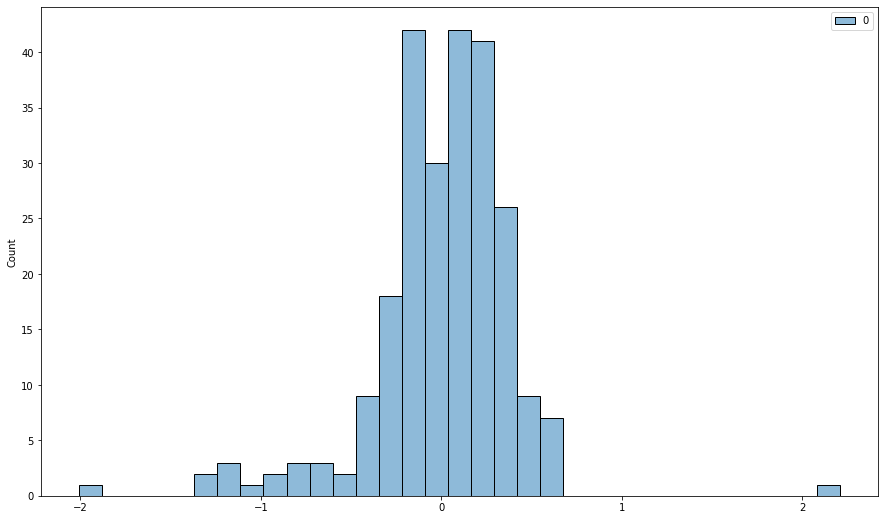

In [90]:
resid = predicted - y_test.values.reshape(-1,1)
sns.histplot(resid);

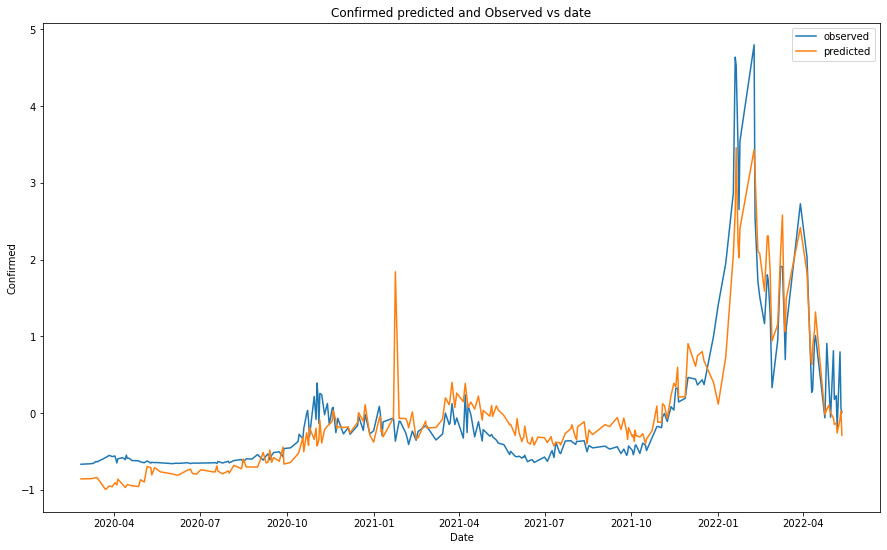

In [91]:
plot_date_observed_vs_predicted_confirmed(predicted);

## Model 2 - predykcja śmierci</br>



### Dane kumulacyjne
Do tego modelu wybiore `recovered`, `icu`,  `month1, `year`

In [92]:
col_name = ['icu', 'people_fully_vaccinated', 'recovered']
X_train, X_test, y_train, y_test = train_test_split(glob_agg[col_name], glob_agg['deaths'], test_size=0.30, random_state=0)

In [93]:
reg = LinearRegression()  
scores = defaultdict(list)

reg.fit(X_train, y_train.values.reshape(-1,1))

predicted = reg.predict(X_test)

print_stats(col_name, predicted, y_test)


In [94]:
scores_model_2 = pd.DataFrame(scores)

scores_model_2

r2  max_error     rmse
0  0.813181   1.575837  0.18217

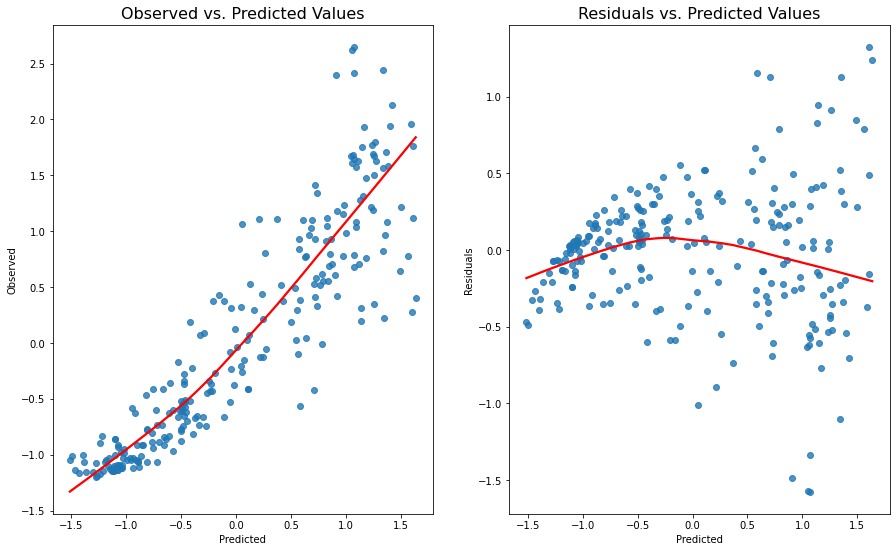

In [95]:
plot_observed_and_residuals_vs_predicted()

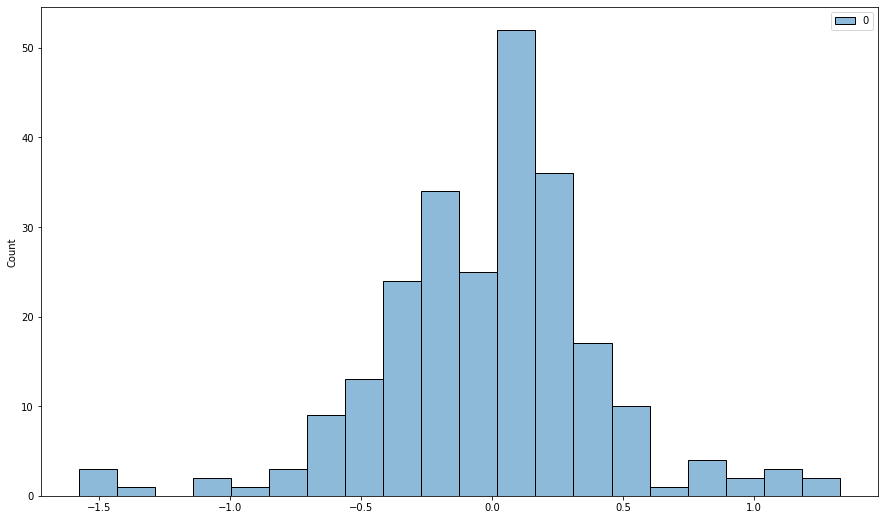

In [96]:
resid = predicted - y_test.values.reshape(-1,1)
sns.histplot(resid);

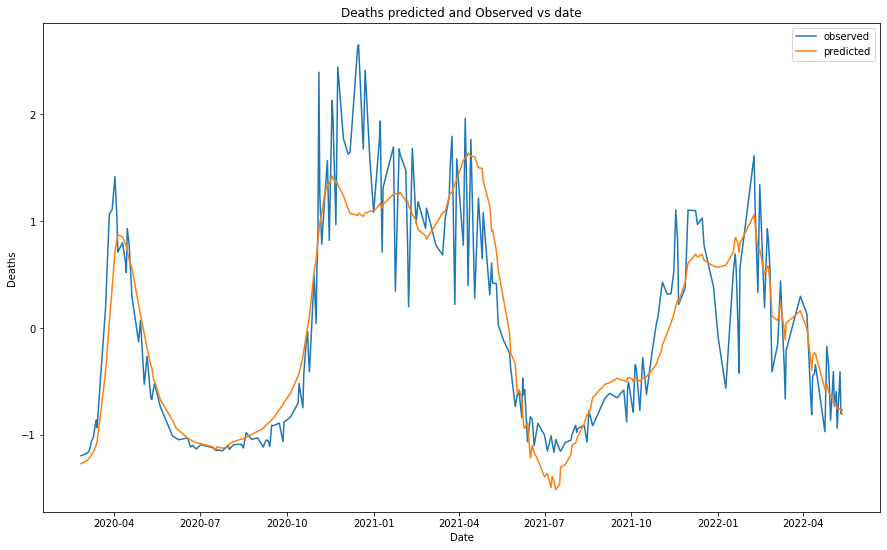

In [97]:
plot_date_observed_vs_predicted_deaths(predicted);

# Podsumowanie modeli regresji liniowej i wielorakiej dla danych globalnych

W Obu przypadkach dostalsimy dobre wyniki na poziomie >=70% opisowosci danych.

## Zachorowania

Najlepszy model dla regresji liniowej powstal dla zmiennej `recovered` i opisuje dane w 78% z bledem maksymalnym	2.5 jest to imponujacy wynik, natomiast model nie spełnia warunków regresji liniowej(brak homoskedastycznosci oraz rozkladu normalnego residuow). Kolejna najlepsza zmienna ma r2 na poziomie 25% co w porownaniu do modelu wyzej jest fatalnym wynikiem.</br> Model regresji wielorakiej  stworzony dla zmiennych `recovered`, `tests`, `stay_home_restrictions` opisuje dane w 81% z bledem 2.2 jest to wynik identyczny jak dla modelu regresji liniowej. Natomiast zmienil nam sie rozklad residuow, jest bardziej normalny oraz warjancja residow w tym modelu dazy dookola zera, dlatego jako model finalny wybral bym ten model.


## Śmiertelnosc
Dla smiertelnosci najlepszy model regresji liniowej okazal sie dla zmiennej `hosp`  opisuje dane w 78%	z maksymalnym bledem 1.53 ale i rowniez model dla zmioennej `icu` prezentuje sie bardzo dobrze, r2 na poziomie	0.77 z wyzszyn bkeden 1.7. Wszystkie warunki regresji zostaly spelnione dla modelu dla `hosp`. W modelu regresji wielorakiem  nie zostala wykorzystana najlepsza zmienna z modelu liniowego `hosp` ze wzgledu na duza korelacje pomiedzy innymi zmiennymi, dlatego jako zmienna glowna zostala uzyta `icu` wraz z  `people_fully_vaccinated` oraz `recovered`. Dane opisywane sa na poziomie 81% z bledem 1.58. Podsumowując oba modele są praktycznie identyczne, ciezko wybraz faworyta.



# Inne algorytmy

Do tych algorytmów postanowilem użyć tych samych zmiennych co do regresji wielorakiej w celu porównania wynikow.

## Zachorowania


In [104]:
col_name = ['recovered', 'tests', 'stay_home_restrictions']
X_train, X_test, y_train, y_test = train_test_split(glob_agg[col_name], glob_agg['confirmed'], test_size=0.30, random_state=0)

### DecisionTree

In [105]:
reg = DecisionTreeRegressor(random_state=0) 
scores = defaultdict(list)

reg.fit(X_train, y_train)

predicted = reg.predict(X_test)

print_stats(col_name, predicted, y_test)
pd.DataFrame(scores)

r2  max_error      rmse
0  0.789224   2.895812  0.175175

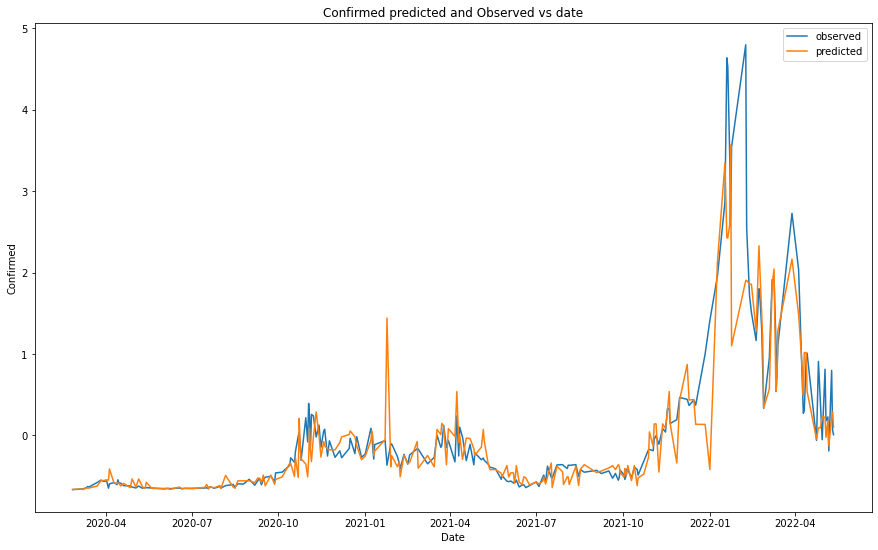

In [106]:
plot_date_observed_vs_predicted_confirmed(predicted);

### SVR

In [107]:

reg = make_pipeline(StandardScaler(), SVR())
scores = defaultdict(list)

reg.fit(X_train, y_train)

predicted = reg.predict(X_test)

print_stats(col_name, predicted, y_test)
pd.DataFrame(scores)

r2  max_error      rmse
0  0.878652   1.884337  0.100852

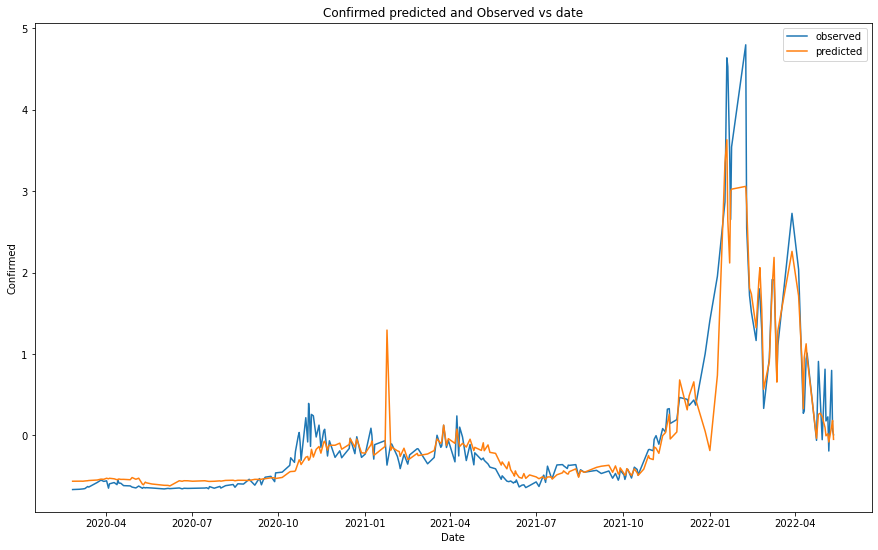

In [108]:
plot_date_observed_vs_predicted_confirmed(predicted);

### RandomForest

In [109]:

reg = RandomForestRegressor()
scores = defaultdict(list)

reg.fit(X_train, y_train)

predicted = reg.predict(X_test)

print_stats(col_name, predicted, y_test)
pd.DataFrame(scores)

r2  max_error      rmse
0  0.882459   2.354145  0.097688

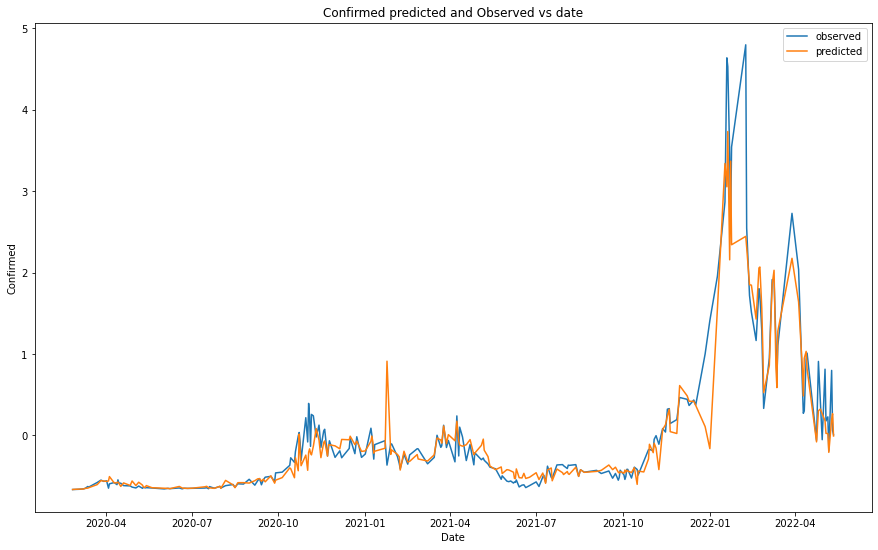

In [110]:
plot_date_observed_vs_predicted_confirmed(predicted);

In [112]:
col_name = ['icu', 'people_fully_vaccinated', 'recovered']
X_train, X_test, y_train, y_test = train_test_split(glob_agg[col_name], glob_agg['deaths'], test_size=0.30, random_state=0)

## Smiertelnosc

### DecisionTree

In [113]:

reg = DecisionTreeRegressor(random_state=0) 
scores = defaultdict(list)

reg.fit(X_train, y_train)

predicted = reg.predict(X_test)

print_stats(col_name, predicted, y_test)
pd.DataFrame(scores)

r2  max_error      rmse
0  0.848657   2.000533  0.147576

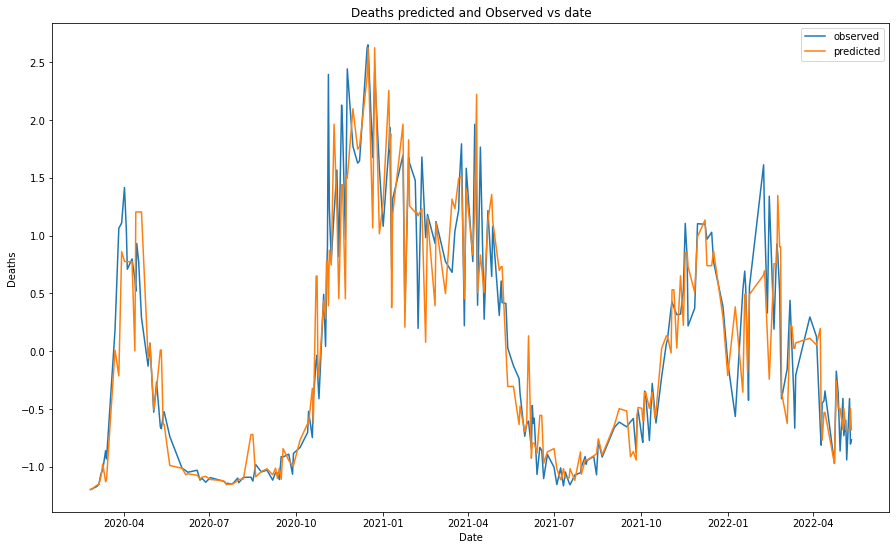

In [114]:
plot_date_observed_vs_predicted_deaths(predicted);

### SVR

In [115]:

reg = make_pipeline(StandardScaler(), SVR())
scores = defaultdict(list)

reg.fit(X_train, y_train.values)

predicted = reg.predict(X_test)

print_stats(col_name, predicted, y_test)
pd.DataFrame(scores)

r2  max_error      rmse
0  0.876769   1.284788  0.120163

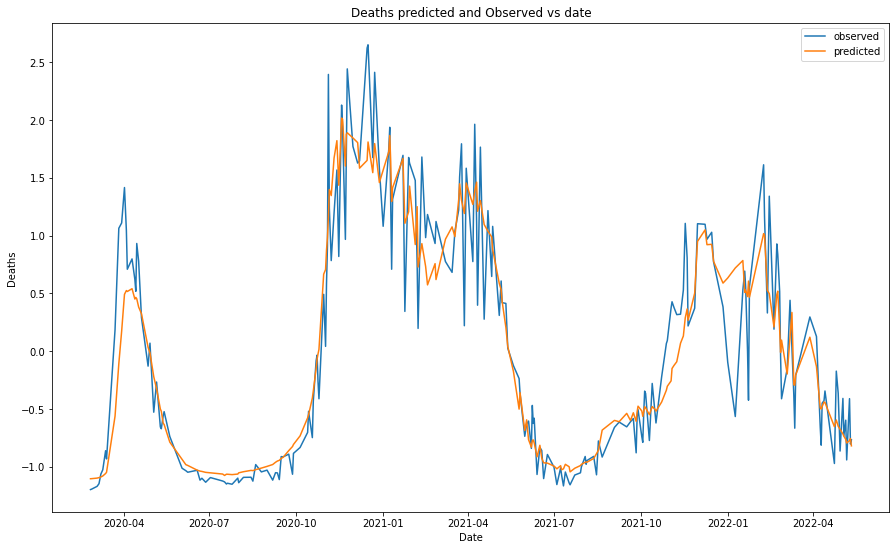

In [116]:
plot_date_observed_vs_predicted_deaths(predicted);

### RandomForest


In [117]:


reg = RandomForestRegressor()
scores = defaultdict(list)

reg.fit(X_train, y_train.values)

predicted = reg.predict(X_test)

print_stats(col_name, predicted, y_test)
pd.DataFrame(scores)

r2  max_error      rmse
0  0.916981   1.756552  0.080953

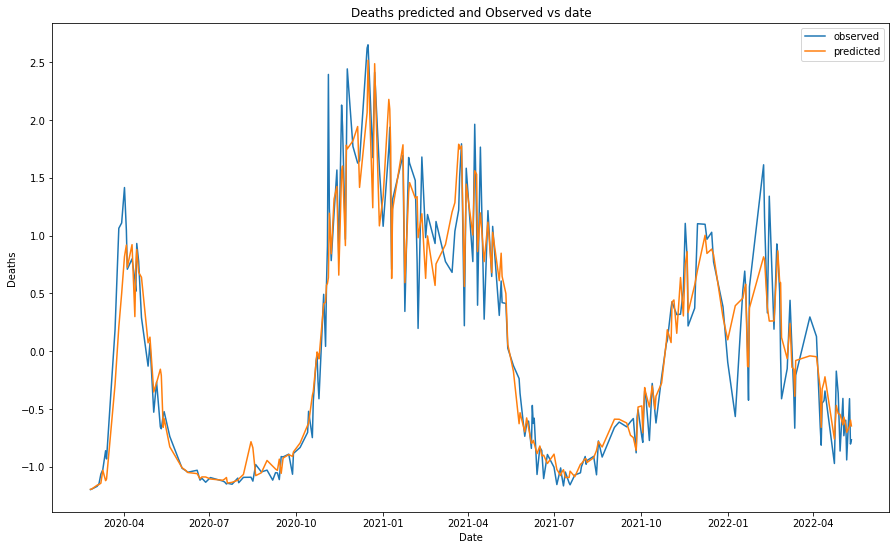

In [118]:
plot_date_observed_vs_predicted_deaths(predicted);

# Porównanie algorytmów

## Zachorowania


Dla zachorowan najlepsze wyniki otrzymalsimy dla algorytmu SVR oraz RandomForest, odpowiednie r2:0.89, max error 1.77 dla SVR oraz 1.9, max erorr 2.4 dla RandomForest. Dla algorytmu drzew decyzyjnych otrzymalismy nieco slabsze wyniki, ale w miare akceptowalne r2 0.79. Najlepszym modelem wydaje sie byc SVR


## Smiertelnosc
Dla tej zmiennej najbardziej wyroznia sie model RandomForest z opisowoscia danych na poziomie 92%. Natomiast maksymalny blad w tym algorytmie jest zdecydowanie wiekszy niz w algorytmie SVR 1.8 do 1.3, r2 w algorytmie dla SVR jest ma poziomie 87%, takze nie odbiega znaczaco od algorytmu RandomForest, dlatego jako najlepszy model wybral bym wlasnie go, poprzez zdecydowanie mniejszy blad maksymalny.


# Local data - Szwecja

# Eksploracja i czyszczenie danych

In [140]:
local

id       date  confirmed   deaths  recovered       tests  \
9670   3e2d4144 2020-02-01        NaN      NaN        NaN         NaN   
9671   3e2d4144 2020-02-02        NaN      NaN        NaN         NaN   
9672   3e2d4144 2020-02-03        NaN      NaN        NaN         NaN   
9673   3e2d4144 2020-02-04        1.0      NaN        NaN         NaN   
9674   3e2d4144 2020-02-05        1.0      NaN        NaN         NaN   
...         ...        ...        ...      ...        ...         ...   
10497  3e2d4144 2022-05-08  2503955.0  18863.0        NaN  18304006.0   
10498  3e2d4144 2022-05-09  2504159.0  18864.0        NaN         NaN   
10499  3e2d4144 2022-05-10  2504526.0  18864.0        NaN         NaN   
10500  3e2d4144 2022-05-11  2504894.0  18864.0        NaN         NaN   
10501  3e2d4144 2022-05-12        NaN      NaN        NaN         NaN   

         vaccines  people_vaccinated  people_fully_vaccinated  hosp  ...  \
9670          NaN                NaN                      NaN   NaN  ...   
9671          NaN                NaN                      NaN   NaN  ...   
9672          NaN                NaN                      NaN   NaN  ...   
9673          NaN                NaN                      NaN   NaN  ...   
9674          NaN                NaN                      NaN   NaN  ...   
...           ...                ...                      ...   ...  ...   
10497         NaN                NaN                      NaN   NaN  ...   
10498         NaN                NaN                      NaN   NaN  ...   
10499         NaN                NaN                      NaN   NaN  ...   
10500         NaN                NaN                      NaN   NaN  ...   
10501  22231642.0          7830804.0                7636781.0   NaN  ...   

       iso_currency  key_local          key_google_mobility  \
9670            SEK        NaN  ChIJ8fA1bTmyXEYRYm-tjaLruCI   
9671            SEK        NaN  ChIJ8fA1bTmyXEYRYm-tjaLruCI   
9672            SEK        NaN  ChIJ8fA1bTmyXEYRYm-tjaLruCI   
9673            SEK        NaN  ChIJ8fA1bTmyXEYRYm-tjaLruCI   
9674            SEK        NaN  ChIJ8fA1bTmyXEYRYm-tjaLruCI   
...             ...        ...                          ...   
10497           SEK        NaN  ChIJ8fA1bTmyXEYRYm-tjaLruCI   
10498           SEK        NaN  ChIJ8fA1bTmyXEYRYm-tjaLruCI   
10499           SEK        NaN  ChIJ8fA1bTmyXEYRYm-tjaLruCI   
10500           SEK        NaN  ChIJ8fA1bTmyXEYRYm-tjaLruCI   
10501           SEK        NaN  ChIJ8fA1bTmyXEYRYm-tjaLruCI   

       key_apple_mobility  key_jhu_csse  key_nuts  key_gadm  month  year  day  
9670               Sweden            SE       NaN       SWE      2  2020    1  
9671               Sweden            SE       NaN       SWE      2  2020    2  
9672               Sweden            SE       NaN       SWE      2  2020    3  
9673               Sweden            SE       NaN       SWE      2  2020    4  
9674               Sweden            SE       NaN       SWE      2  2020    5  
...                   ...           ...       ...       ...    ...   ...  ...  
10497              Sweden            SE       NaN       SWE      5  2022    8  
10498              Sweden            SE       NaN       SWE      5  2022    9  
10499              Sweden            SE       NaN       SWE      5  2022   10  
10500              Sweden            SE       NaN       SWE      5  2022   11  
10501              Sweden            SE       NaN       SWE      5  2022   12  

[832 rows x 50 columns]

In [141]:
corr = local.corr()
corr.style.background_gradient(cmap='coolwarm')

/usr/local/lib/python3.7/dist-packages/pandas/io/formats/style.py:2813: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/usr/local/lib/python3.7/dist-packages/pandas/io/formats/style.py:2814: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


Odrzucmy zmienne, ktore na pewno nie przydadza sie do dalszej analizy

In [142]:
local = local[local.columns.drop(list(local.filter(regex='administrative.*')))]
local = local[local.columns.drop(list(local.filter(regex='iso.*')))]
local = local[local.columns.drop(list(local.filter(regex='key*')))]
local.drop(['recovered','vent', 'latitude', 'longitude', 'population',
              'internal_movement_restrictions',  
            'international_movement_restrictions', 'information_campaigns', 
            'testing_policy', 'facial_coverings', 'elderly_people_protection','id'
           ],  axis=1, inplace=True)



In [143]:
local.isnull().mean()

date                         0.000000
confirmed                    0.004808
deaths                       0.048077
tests                        0.183894
vaccines                     0.914663
people_vaccinated            0.914663
people_fully_vaccinated      0.915865
hosp                         0.105769
icu                          0.105769
school_closing               0.002404
workplace_closing            0.002404
cancel_events                0.002404
gatherings_restrictions      0.002404
transport_closing            0.002404
stay_home_restrictions       0.002404
contact_tracing              0.002404
vaccination_policy           0.002404
government_response_index    0.002404
stringency_index             0.002404
containment_health_index     0.002404
economic_support_index       0.002404
month                        0.000000
year                         0.000000
day                          0.000000
dtype: float64

In [144]:
local

date  confirmed   deaths       tests    vaccines  \
9670  2020-02-01        NaN      NaN         NaN         NaN   
9671  2020-02-02        NaN      NaN         NaN         NaN   
9672  2020-02-03        NaN      NaN         NaN         NaN   
9673  2020-02-04        1.0      NaN         NaN         NaN   
9674  2020-02-05        1.0      NaN         NaN         NaN   
...          ...        ...      ...         ...         ...   
10497 2022-05-08  2503955.0  18863.0  18304006.0         NaN   
10498 2022-05-09  2504159.0  18864.0         NaN         NaN   
10499 2022-05-10  2504526.0  18864.0         NaN         NaN   
10500 2022-05-11  2504894.0  18864.0         NaN         NaN   
10501 2022-05-12        NaN      NaN         NaN  22231642.0   

       people_vaccinated  people_fully_vaccinated  hosp  icu  school_closing  \
9670                 NaN                      NaN   NaN  NaN             0.0   
9671                 NaN                      NaN   NaN  NaN             0.0   
9672                 NaN                      NaN   NaN  NaN             0.0   
9673                 NaN                      NaN   NaN  NaN             0.0   
9674                 NaN                      NaN   NaN  NaN             0.0   
...                  ...                      ...   ...  ...             ...   
10497                NaN                      NaN   NaN  NaN             0.0   
10498                NaN                      NaN   NaN  NaN             0.0   
10499                NaN                      NaN   NaN  NaN             0.0   
10500                NaN                      NaN   NaN  NaN             NaN   
10501          7830804.0                7636781.0   NaN  NaN             NaN   

       ...  stay_home_restrictions  contact_tracing  vaccination_policy  \
9670   ...                     0.0              2.0                 0.0   
9671   ...                     0.0              2.0                 0.0   
9672   ...                     0.0              2.0                 0.0   
9673   ...                     0.0              2.0                 0.0   
9674   ...                     0.0              2.0                 0.0   
...    ...                     ...              ...                 ...   
10497  ...                     0.0              0.0                 5.0   
10498  ...                     0.0              0.0                 5.0   
10499  ...                     0.0              0.0                 5.0   
10500  ...                     NaN              NaN                 NaN   
10501  ...                     NaN              NaN                 NaN   

       government_response_index  stringency_index  containment_health_index  \
9670                       11.46              5.56                     13.10   
9671                       11.46              5.56                     13.10   
9672                       11.46              5.56                     13.10   
9673                       11.46              5.56                     13.10   
9674                       11.46              5.56                     13.10   
...                          ...               ...                       ...   
10497                      21.87             11.11                     21.43   
10498                      21.87             11.11                     21.43   
10499                      21.87             11.11                     21.43   
10500                        NaN               NaN                       NaN   
10501                        NaN               NaN                       NaN   

       economic_support_index  month  year  day  
9670                      0.0      2  2020    1  
9671                      0.0      2  2020    2  
9672                      0.0      2  2020    3  
9673                      0.0      2  2020    4  
9674                      0.0      2  2020    5  
...                       ...    ...   ...  ...  
10497                    25.0      5  2022    8  
10498               

Zmienna `tests` posiada braki na poziomie 20% danych, po wstepnej eksploracji uwazam, ze  jest to spowodowane tym, ze w początkowych fazach choroby testy nie byly publikowane przez rząd Szewcji lub nie byly wykonywane, zastąpie ja wartoscią 0. Braki w zmiennych `confirmed` i `deaths` rowniez wystepuja na poczatku, tez zastapie je zerem.</br>
Duze braki przy zmiennych  `vaccines`, `people_vaccinated`, `people_fully_vaccinated`, wynikaja z tego, że Szwecja zliczala zaszczepienia tygodniowo. Nie jest to problem, wartosciom nan przypiszemy wartosc z odpowiedniego tygodnia</br>
Zmienne `hosp` i `icu` nie sa zmiennymi kumulatywnymi i braki sa zsynchronizowane z brakami w zmiennej `confirmed`, dlatego zshiftuje dataframe o 24 wiersze, poniewaz wczesniej w `confirmed` znajduja sie same 1, co moze zaburzyc obliczenia.


In [145]:
local = local.iloc[24:,]

In [146]:
np.random.seed(42)

local = local.dropna(axis=0, subset=[ 'school_closing'])
local['deaths'].fillna(0, inplace=True)
local['icu'].fillna(0, inplace=True)
local['hosp'].fillna(0, inplace=True)
local['tests'].fillna(0, inplace=True)


temp = [0,0,0] 
for index, row in local.iterrows():

    if not np.isnan(row['vaccines']):
      temp = [row['vaccines'], row['people_vaccinated'], row['people_fully_vaccinated']]

    local.at[index,'vaccines'] =  temp[0]
    local.at[index,'people_vaccinated'] = temp[1]
    local.at[index,'people_fully_vaccinated'] = temp[2]

local['people_fully_vaccinated']=local['people_fully_vaccinated'].fillna(0)

col_to_replace = [ 'school_closing', 'workplace_closing', 'cancel_events', 'gatherings_restrictions', 'transport_closing', 'stay_home_restrictions', 'contact_tracing', 'vaccination_policy']


local.isnull().mean()

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


date                         0.0
confirmed                    0.0
deaths                       0.0
tests                        0.0
vaccines                     0.0
people_vaccinated            0.0
people_fully_vaccinated      0.0
hosp                         0.0
icu                          0.0
school_closing               0.0
workplace_closing            0.0
cancel_events                0.0
gatherings_restrictions      0.0
transport_closing            0.0
stay_home_restrictions       0.0
contact_tracing              0.0
vaccination_policy           0.0
government_response_index    0.0
stringency_index             0.0
containment_health_index     0.0
economic_support_index       0.0
month                        0.0
year                         0.0
day                          0.0
dtype: float64

Ustawiam index jako date

In [147]:
local.set_index('date', inplace=True)

Ponieważ zamierzam uzyć zmiennych kategorycznych w moich modelach, mapuje ich wartosci na arbitralna liczbe wystąpien

In [148]:
local[col_to_replace]=local[col_to_replace].astype('int') 

for col in col_to_replace:
  local[col] = local[col].map({v:i for i, v in enumerate(local[col])})


for col in ['month', 'year', 'day']:
  local[col] = local[col].map({v:i for i, v in enumerate(local[col])})
  

Tak jak w przypadku danych globalnych obliczam przyrosty dzienne dla danych zmiennych

In [149]:
cols = ['confirmed', 'deaths', 'tests', 'vaccines', 'people_vaccinated', 'people_fully_vaccinated']
local_agg = local.copy()
for col in cols:
  local_agg[col] = local_agg[col].diff()


local_agg =local_agg[1:]

In [150]:
min = local_agg['tests'].min()
local_agg=local_agg[local_agg['tests'] > min] 

Zobaczmy rozklady zmiennych

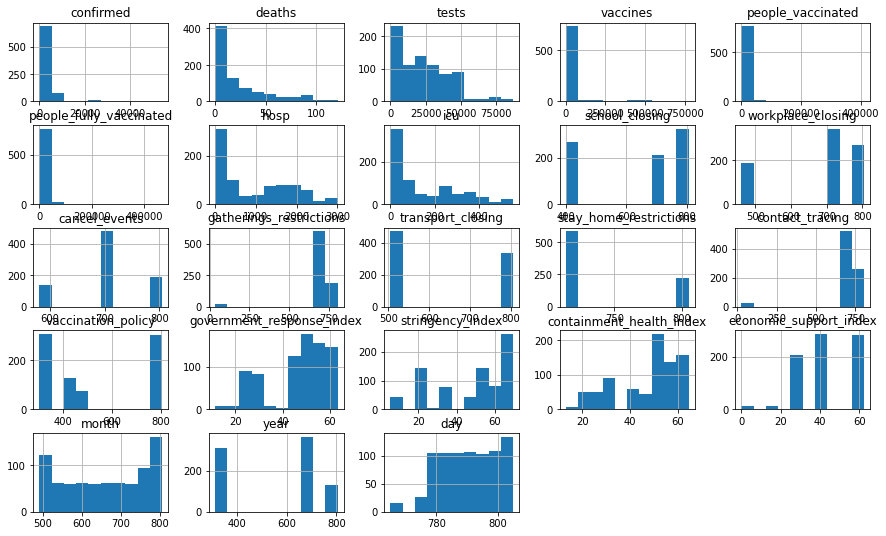

In [151]:
local_agg.hist();

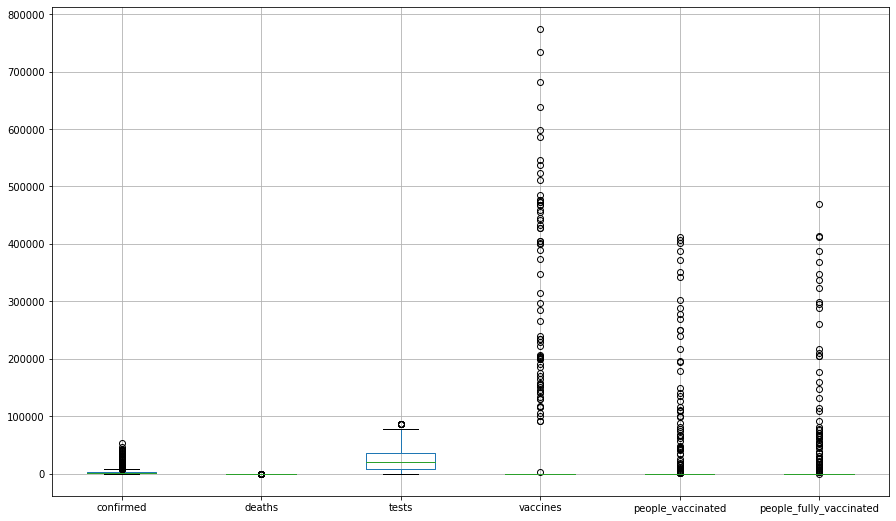

In [152]:
local_agg[cols].boxplot()

Zobaczmy jak wyglądają korelacje 

In [153]:
corr = local_agg.corr()
corr.style.background_gradient(cmap='coolwarm')

Można zauważyć, że nie jest kolorowo

Sprawdzmy zależnosci pomiedzy zmiennymi oraz rozklady

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


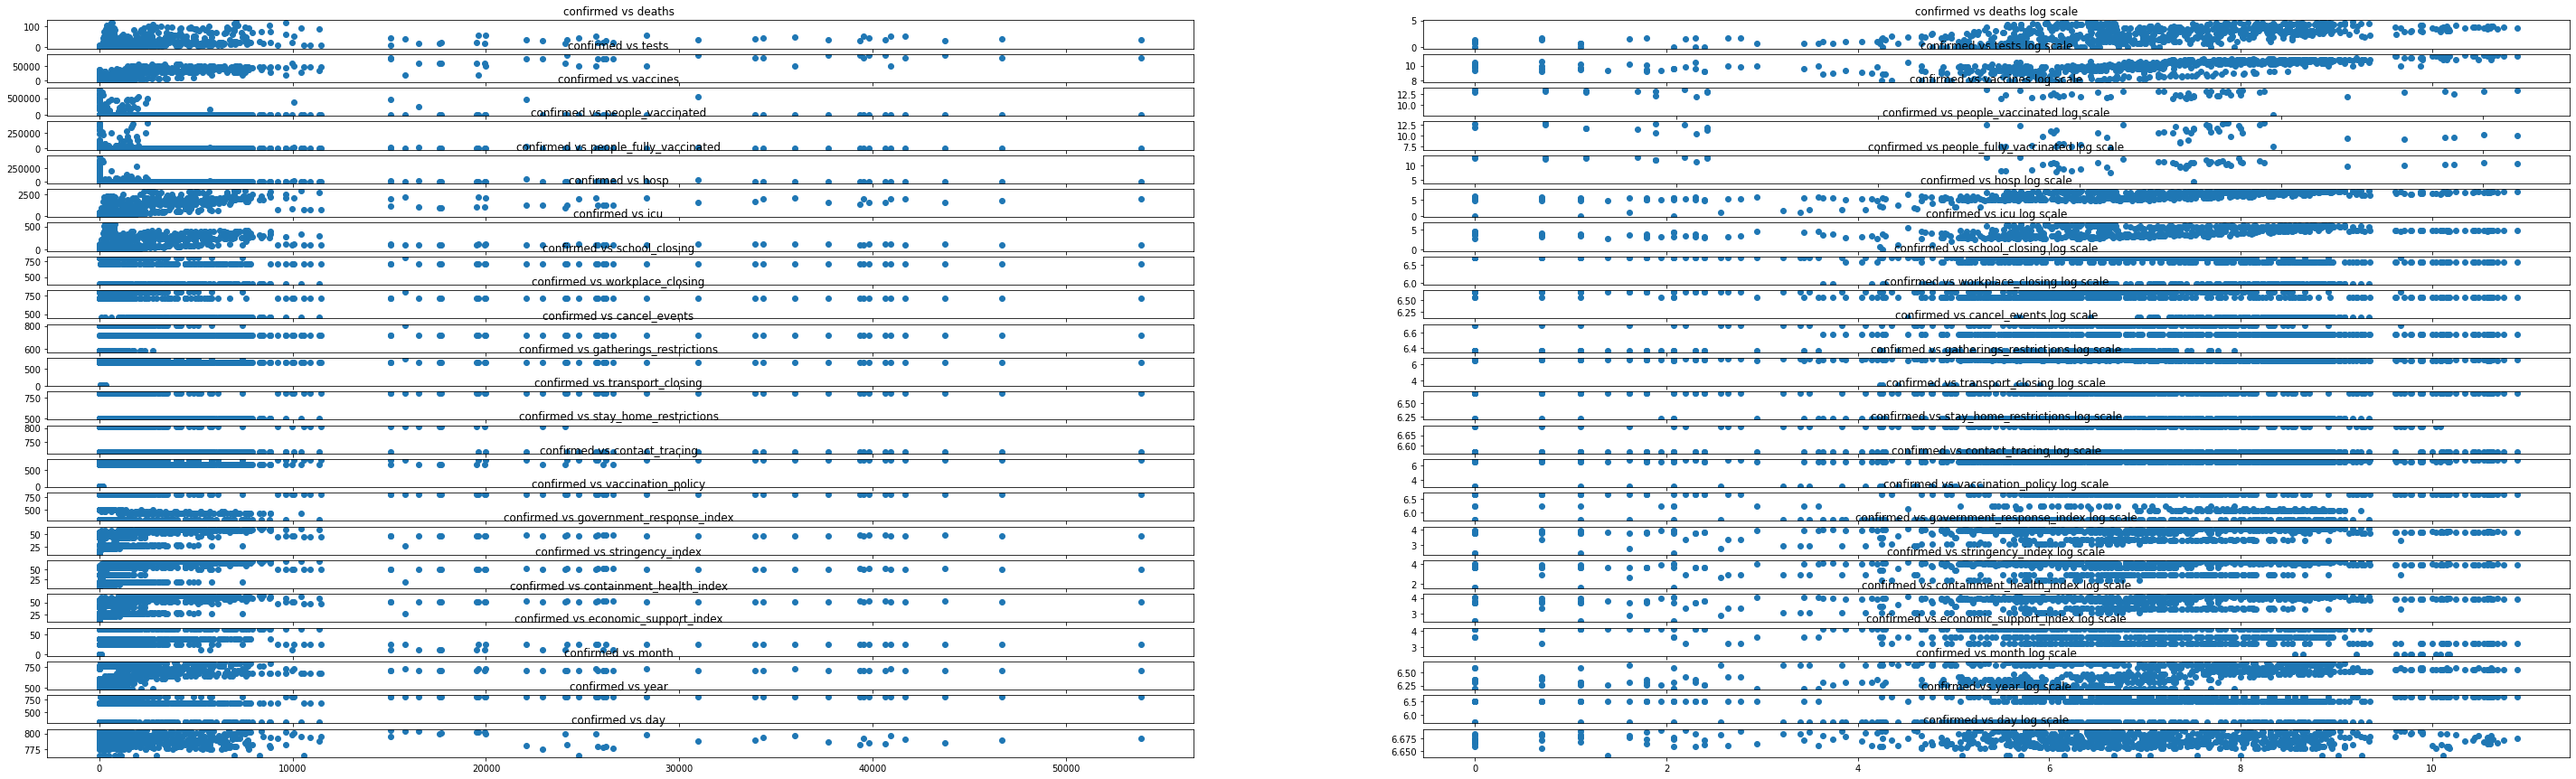

In [154]:
plot_scatter_normal_and_log('confirmed', local_agg)

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


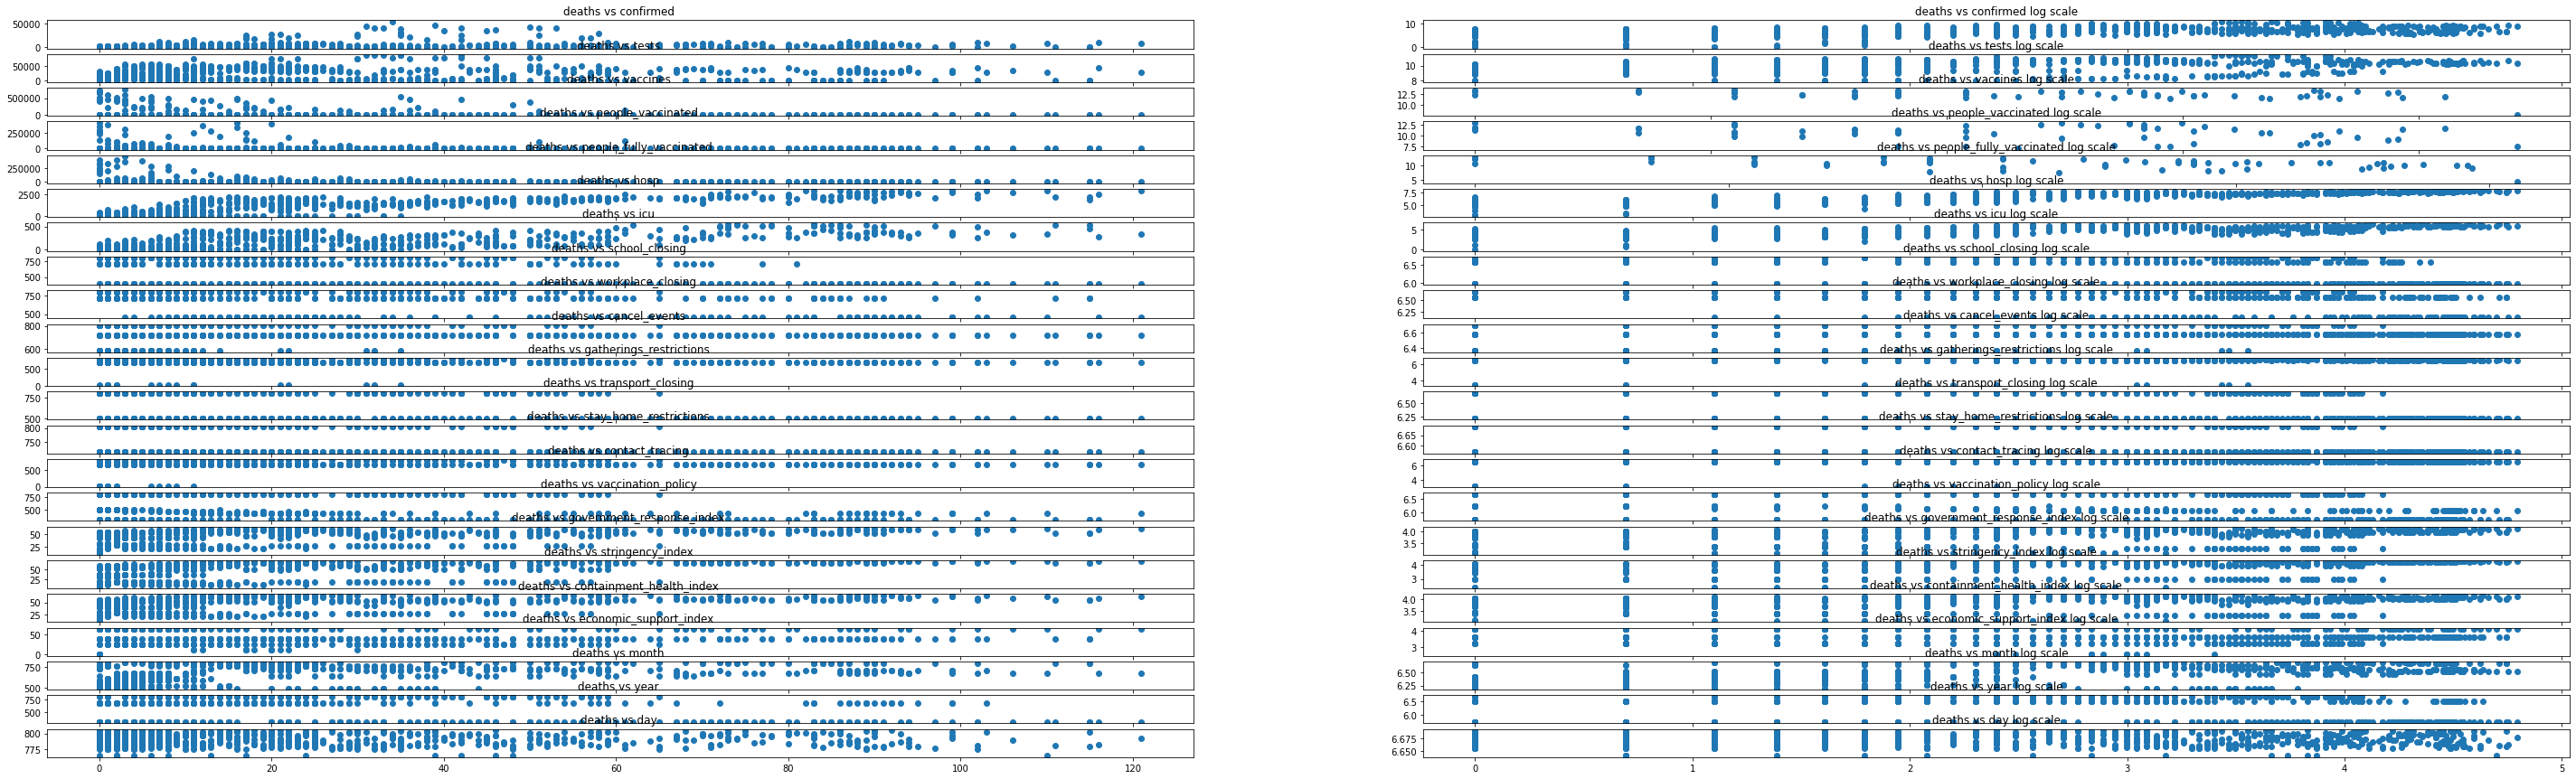

In [155]:
plot_scatter_normal_and_log('deaths', local_agg);

Zarówno w skali normalnej jak i logarytmicznej liniowosc zbytnio sie nie rozni, do dalszej analizy nie bede transformowal danych.

Ustandaryzujmy dane przed tworzeniem modelow

In [181]:

sc = StandardScaler()
columns = local_agg.columns.tolist()
indexes = local_agg.index
scaled = sc.fit_transform(local_agg[columns].values)
local_agg = pd.DataFrame(scaled, columns=columns, index=indexes)


# Tworzenie modeli

## Regresja liniowa 

### Predykcja zachorowań

In [226]:
col_name = local_agg.columns.to_list()
col_name.remove('confirmed')


X_train, X_test, y_train, y_test = train_test_split(local_agg[col_name], local_agg['confirmed'], test_size=0.30, random_state=0)


In [227]:
reg = LinearRegression()
scores = defaultdict(list)
for col in col_name:
  reg.fit(X_train[col].values.reshape(-1,1), y_train.values.reshape(-1,1))
  predicted = reg.predict(X_test[col].values.reshape(-1,1))
  print_stats(col, predicted, y_test)

scored_local_deaths = pd.DataFrame(scores, index=col_name).sort_values("r2", ascending=0)

scored_local_deaths

r2  max_error      rmse
tests                      0.400974   3.884176  0.426162
hosp                       0.096895   6.110433  0.642491
year                       0.033095   6.014070  0.687880
workplace_closing          0.028784   6.443951  0.690947
containment_health_index   0.027302   6.338827  0.692001
deaths                     0.016936   6.338225  0.699376
stringency_index           0.016826   6.373662  0.699454
government_response_index  0.013432   6.384322  0.701869
month                      0.012487   6.331473  0.702541
contact_tracing            0.004256   6.291422  0.708397
icu                        0.004176   6.419422  0.708453
stay_home_restrictions     0.002602   6.353357  0.709573
people_fully_vaccinated   -0.006253   6.389596  0.715873
people_vaccinated         -0.008047   6.389938  0.717149
vaccination_policy        -0.008947   6.096318  0.717789
vaccines                  -0.010865   6.399161  0.719154
gatherings_restrictions   -0.011469   6.402044  0.719584
economic_support_index    -0.011742   6.133887  0.719778
cancel_events             -0.011871   6.402241  0.719869
day                       -0.012541   6.397396  0.720347
school_closing            -0.015600   6.391333  0.722522
transport_closing         -0.023851   6.184863  0.728393

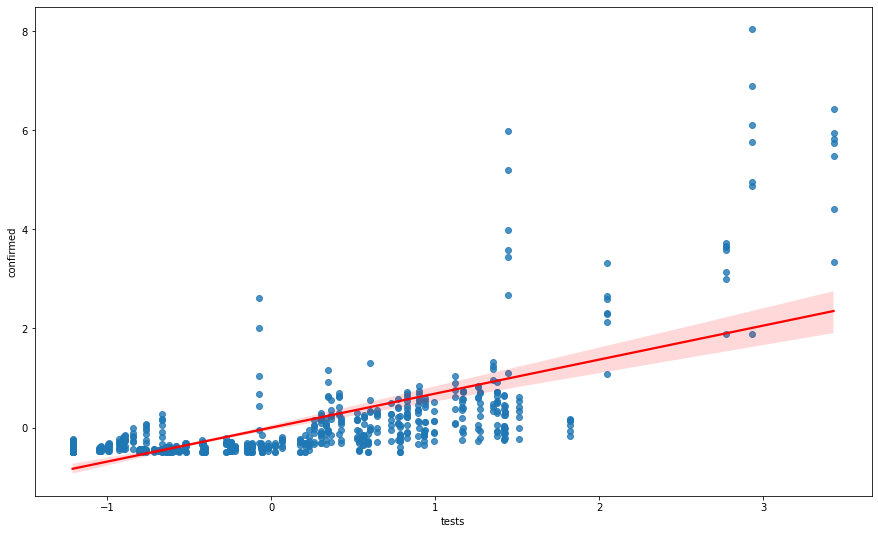

In [228]:
sns.regplot(x=local_agg['tests'], y=local_agg['confirmed'], line_kws={'color': 'red'});  


Widzimy, że liniowość jest spełniona

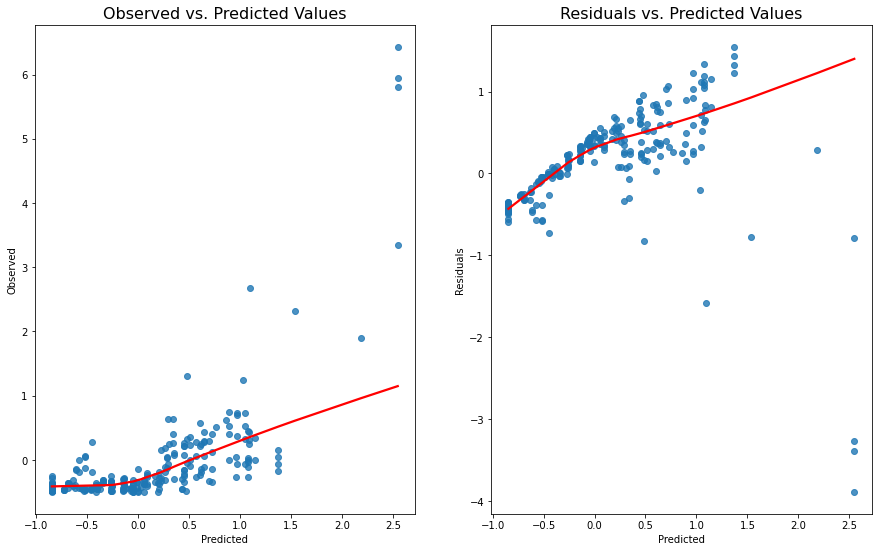

In [229]:
X_train, X_test, y_train, y_test = train_test_split(local_agg['tests'], local_agg['confirmed'], test_size=0.30, random_state=0)
reg = LinearRegression().fit(X_train.values.reshape(-1,1), y_train.values.reshape(-1,1))

predicted = reg.predict(X_test.values.reshape(-1,1))
resid = predicted- y_test.values.reshape(-1,1)

plot_observed_and_residuals_vs_predicted()

Wariancja oscyluje wokół zera.

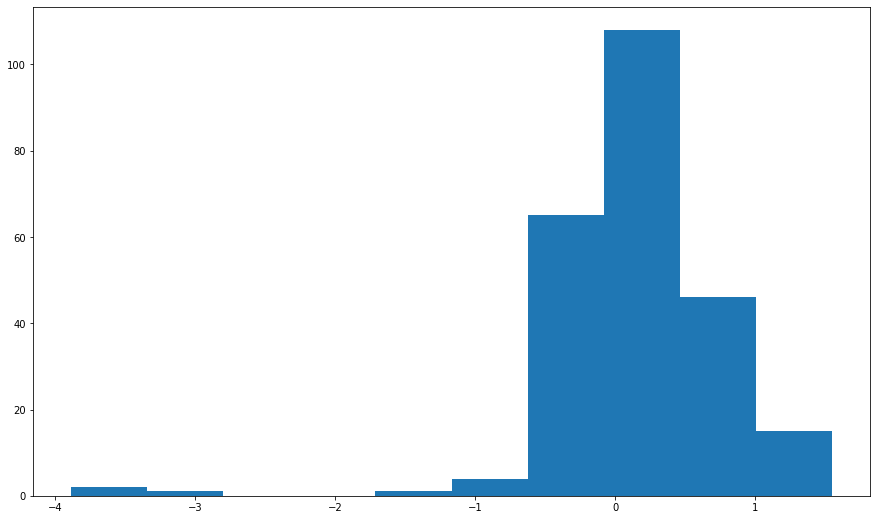

In [230]:
plt.hist(resid);

Brak rozkladu normalnego residuów. </br>

Warunki regresji liniowej nie zostaly spełnione.

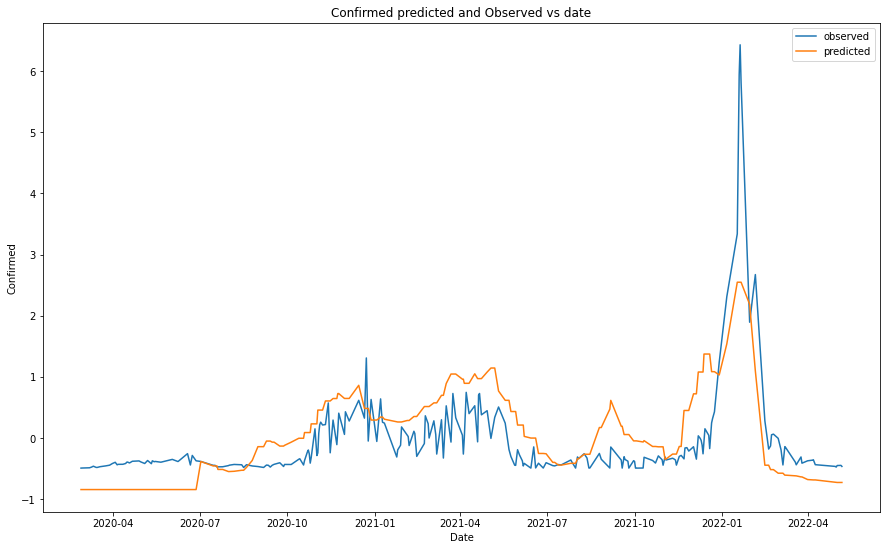

In [231]:
plot_date_observed_vs_predicted_confirmed(predicted);

### Predykcja zgonów





In [188]:
col_name = local.columns.to_list()

col_name.remove('deaths')


X_train, X_test, y_train, y_test = train_test_split(local_agg[col_name], local_agg['deaths'], test_size=0.30, random_state=0)

In [189]:
reg = LinearRegression()
scores = defaultdict(list)

for col in col_name:
  reg.fit(X_train[col].values.reshape(-1,1), y_train.values.reshape(-1,1))
  predicted = reg.predict(X_test[col].values.reshape(-1,1))
  print_stats(col, predicted, y_test)


scored_local_deaths = pd.DataFrame(scores, index=col_name).sort_values("r2", ascending=0)
scored_local_deaths

r2  max_error      rmse
hosp                       0.697215   2.128596  0.319141
icu                        0.538782   2.682401  0.486132
school_closing             0.330351   2.872610  0.705823
stringency_index           0.186411   3.140258  0.857539
month                      0.162882   3.552966  0.882339
containment_health_index   0.127930   3.216816  0.919179
workplace_closing          0.122660   3.458665  0.924733
government_response_index  0.105075   3.224996  0.943268
transport_closing          0.103890   3.336235  0.944518
vaccination_policy         0.099409   3.464674  0.949240
stay_home_restrictions     0.066662   3.448430  0.983756
year                       0.049978   3.362100  1.001342
confirmed                  0.037066   3.452869  1.014951
people_fully_vaccinated    0.011120   3.555924  1.042298
vaccines                   0.009146   3.550793  1.044379
people_vaccinated          0.004359   3.560353  1.049425
gatherings_restrictions    0.000116   3.577982  1.053898
contact_tracing           -0.000574   3.587185  1.054624
cancel_events             -0.002922   3.575978  1.057099
economic_support_index    -0.003590   3.663732  1.057804
day                       -0.004160   3.588854  1.058404
tests                     -0.012592   3.556660  1.067292

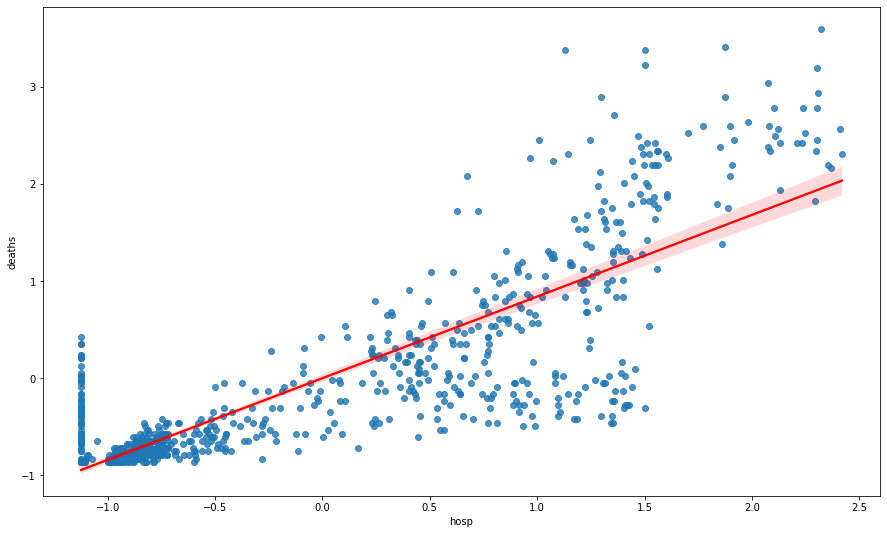

In [190]:
sns.regplot(x=local_agg['hosp'], y=local_agg['deaths'], line_kws={'color': 'red'});  


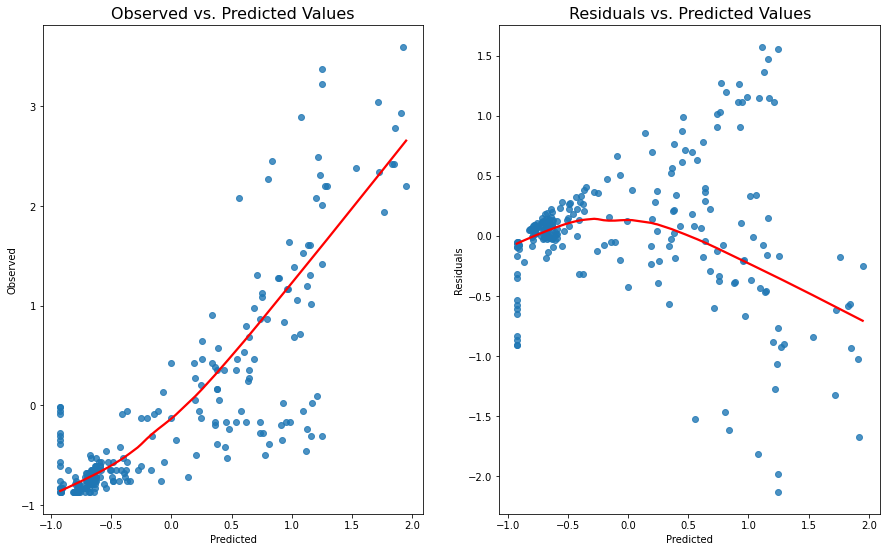

In [191]:
X_train, X_test, y_train, y_test = train_test_split(local_agg['hosp'], local_agg['deaths'], test_size=0.30, random_state=0)
reg = LinearRegression().fit(X_train.values.reshape(-1,1), y_train.values.reshape(-1,1))

predicted = reg.predict(X_test.values.reshape(-1,1))
resid = predicted - y_test.values.reshape(-1,1)

plot_observed_and_residuals_vs_predicted()

 Patrząc na wykres residual vs predicted values, mozna zauwazyc, ze wariancja oscyluje dookola zera. Model przewiduje gorzej dla wyzszych wartosci. Mozna powiedziec, ze homoscedastycznosc nie wystepuje. 

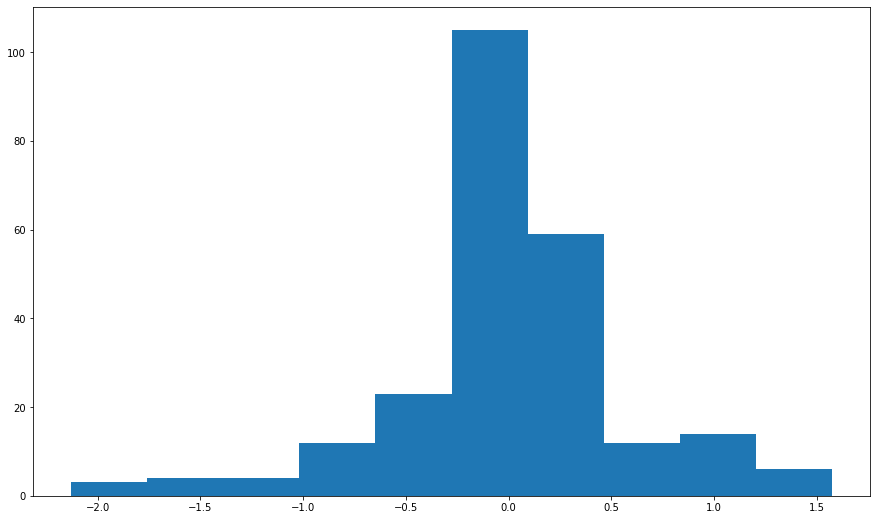

In [192]:
plt.hist(resid);

Rozkład residuów jest normalny.

Warunki regresji liniowej  nie są spełnione

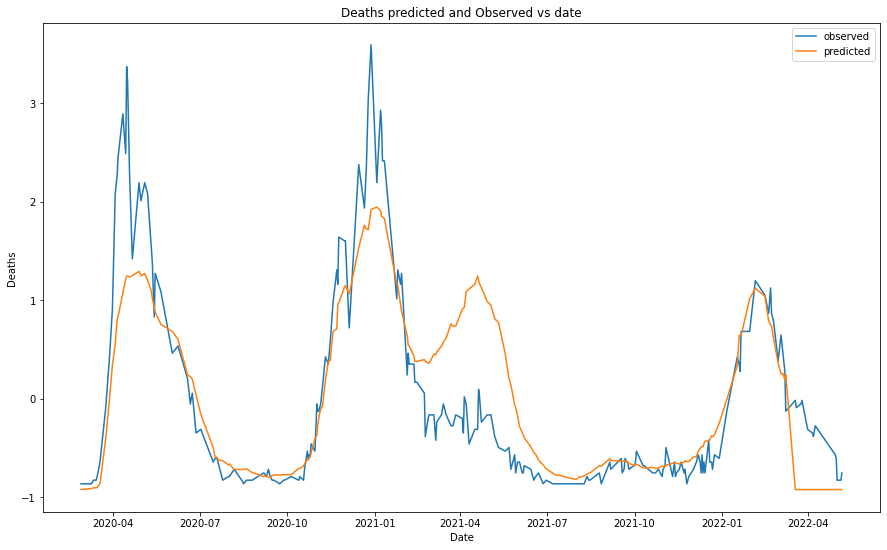

In [193]:
plot_date_observed_vs_predicted_deaths(predicted);

# Model regresji wielorakiej

Popatrzmy jeszcze raz na macierz korelacji

In [194]:
corr = local_agg.corr()
corr.style.background_gradient(cmap='coolwarm')

Na pierwszy rzut oka ciężko jest zauważyć zależności pomiędzy zmiennymi

## Predykcja zachorowań

DO modelu użyje zmiennych `tests`, `economic_support_index`, `transport_closing` ze wzgledu na najwyższe korelacje.

In [195]:
col_name = ['tests','economic_support_index',  'transport_closing']
X_train, X_test, y_train, y_test = train_test_split(local_agg[col_name], local_agg['confirmed'], test_size=0.30, random_state=0)


In [196]:

reg = LinearRegression()  
scores = defaultdict(list)

reg.fit(X_train, y_train.values.reshape(-1,1))

predicted = reg.predict(X_test)

print_stats(X_test, predicted, y_test)

pd.DataFrame(scores)


r2  max_error      rmse
0  0.404415   3.604507  0.423714

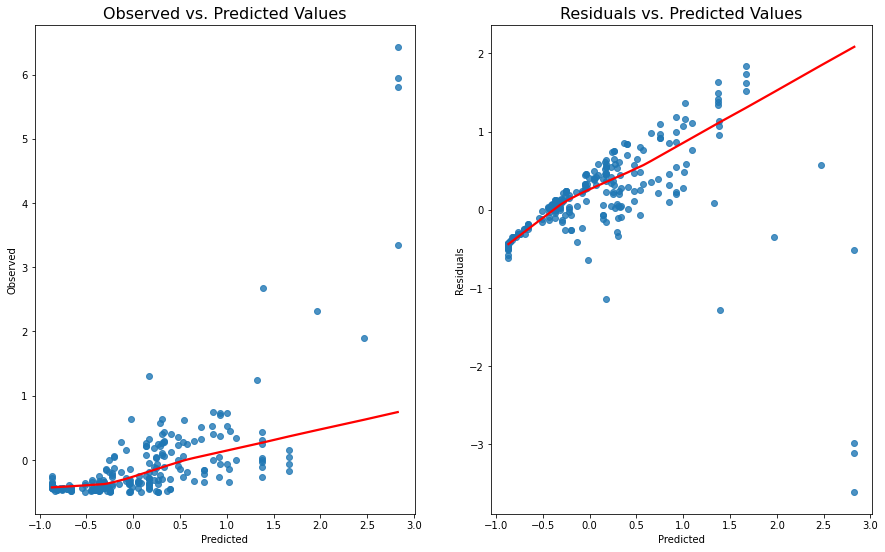

In [197]:
plot_observed_and_residuals_vs_predicted()

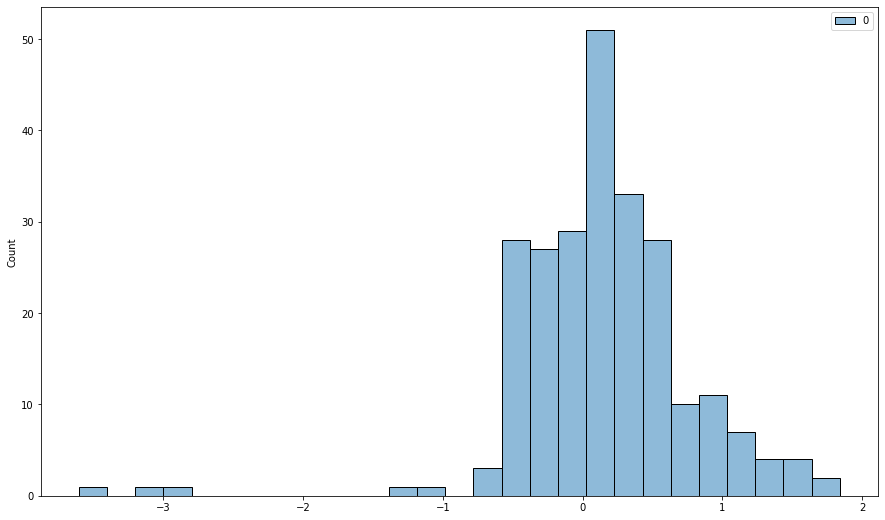

In [198]:
resid = predicted - y_test.values.reshape(-1,1)
sns.histplot(resid);

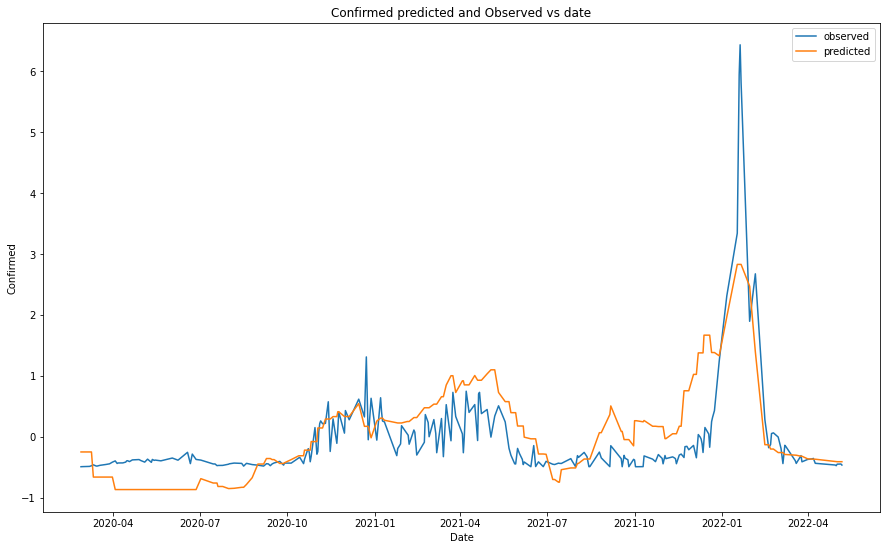

In [199]:
plot_date_observed_vs_predicted_confirmed(predicted);

## Predykcja zgonów

Dla zmiennej `deaths` utworze model ze zmiennymi:
 `gosp`, `year`, `vaccines` </br>


In [201]:
col_name = ['hosp', 'year', 'vaccines']
X_train, X_test, y_train, y_test = train_test_split(local_agg[col_name], local_agg['deaths'], test_size=0.30, random_state=0)


In [202]:
reg = LinearRegression()  
scores = defaultdict(list)

reg.fit(X_train, y_train.values.reshape(-1,1))

predicted = reg.predict(X_test)

print_stats(X_test, predicted, y_test)

pd.DataFrame(scores)

r2  max_error      rmse
0  0.72146   2.012623  0.293587

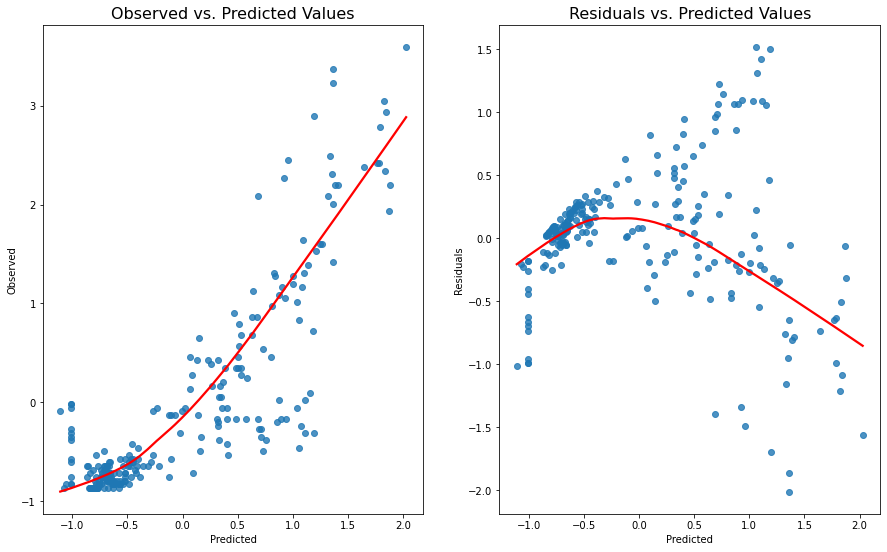

In [203]:
plot_observed_and_residuals_vs_predicted()

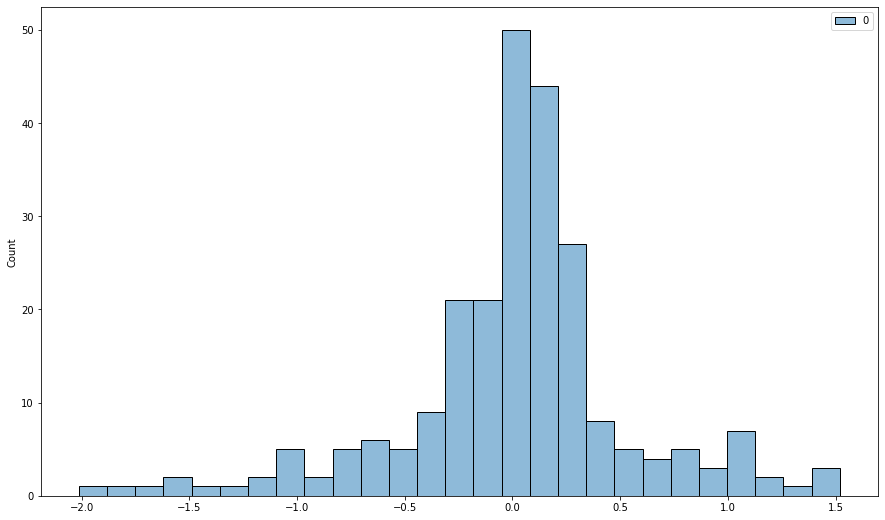

In [204]:
resid = predicted - y_test.values.reshape(-1,1)
sns.histplot(resid);

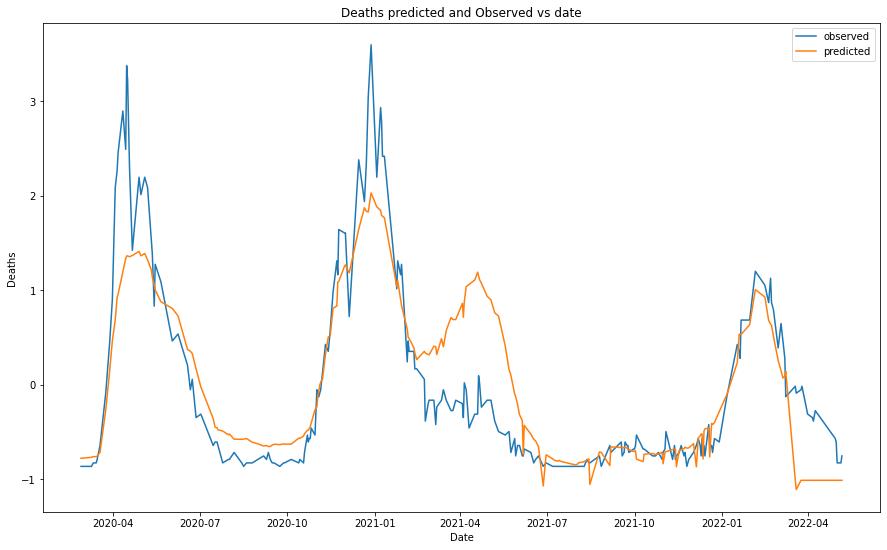

In [205]:
plot_date_observed_vs_predicted_deaths(predicted);

# Podsumowanie modeli regresji liniowej i wielorakiej dla danych lokalnych




## Potwierdzone przypadki

Model regresji liniowej wyszedł bardzo słabo. Najlepszy model opisuje  dane w 40% z bledem 3.9, jest to dosyc wysoki blad. Nie jest to  imponujący wynik. Porównując go do modelu z regresji wielorakiej, ten również nie działa efektywnie, ponieważ jest to opiswość danych rowniez na poziomie 40%, z bledem mniejszym bledem o 0.3%. W żadnym z tym modeli warunki regresji nie zostaly spelnione. Mozna wyknuc wniosek, ze zmienne dolozone do modelu regresji wielorakiem nic nie wnoszą


## Zgony
0.697215	2.128596	0.319141
icu	0.538782	2.682401	0.486132

Prównujac modele regresji liniowe i wielorakiej dla zmiennej `deaths`, najlepszy powstał dla zmiennej `hosp`. Zmienna ta opisuje dane w 70% z w miare akceptowalnym maksymalnym błędem=2.1. Warunki regresji liniowej  zostały spełnione. </br>

Dla regresji wielorakiej model opisuje dane w 72%. Błędy są również podobne do tych z modelu regresji liniowej, z delikatna korzyscia dla regresji wielorakiej.




---

Podsumowując w przypadku predykcji przewidywanych przypadkow wyniki są adekwatne do danych, brak zależnosci pomiedzy zmiennymi, silnej korelacji chociaż z jedną ze zmiennych. W przypadku predykcji smiertelnosci, modele wyszly podobne, oba moglibysmy uzyć, natomiast według mnie lepszy jest model regresji wielorakiej, ponieważ wiecej czynników wplywa na jakość predykcji.


# Sprawdzmy jak działają inne algorytmy

Dla modeli nieliniowych wybralem te same zmienne co do regresji liniowej w celu porównania wyników

## Predykcja zachorowań

In [206]:
col_name = ['tests','economic_support_index',  'transport_closing']
X_train, X_test, y_train, y_test = train_test_split(local_agg[col_name], local_agg['confirmed'], test_size=0.30, random_state=0)


In [207]:

reg = RandomForestRegressor()
scores = defaultdict(list)

reg.fit(X_train, y_train)

predicted = reg.predict(X_test)

print_stats(col_name, predicted, y_test)
pd.DataFrame(scores)

r2  max_error      rmse
0  0.805313   4.239338  0.138505

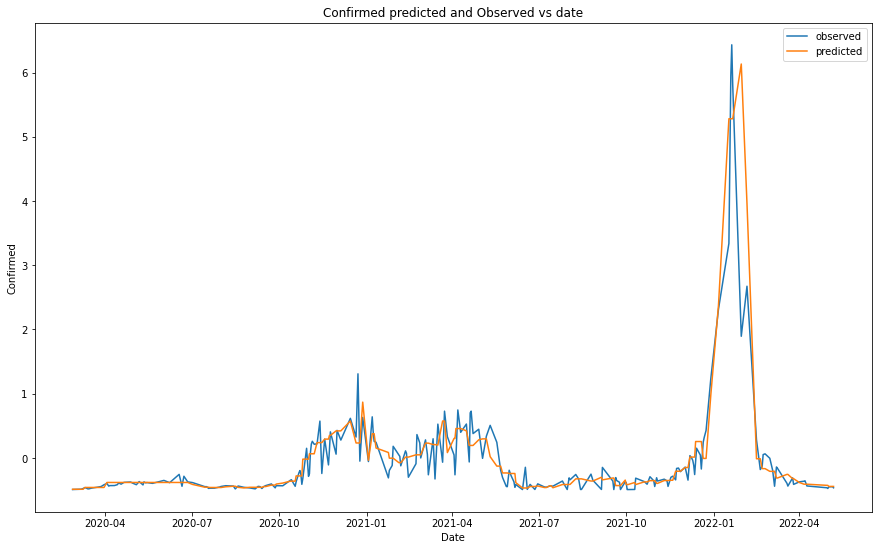

In [208]:
plot_date_observed_vs_predicted_confirmed(predicted);

In [209]:

reg = SVR()
scores = defaultdict(list)

reg.fit(X_train, y_train)

predicted = reg.predict(X_test)

print_stats(col_name, predicted, y_test)
pd.DataFrame(scores)

r2  max_error      rmse
0  0.760815   2.329756  0.170162

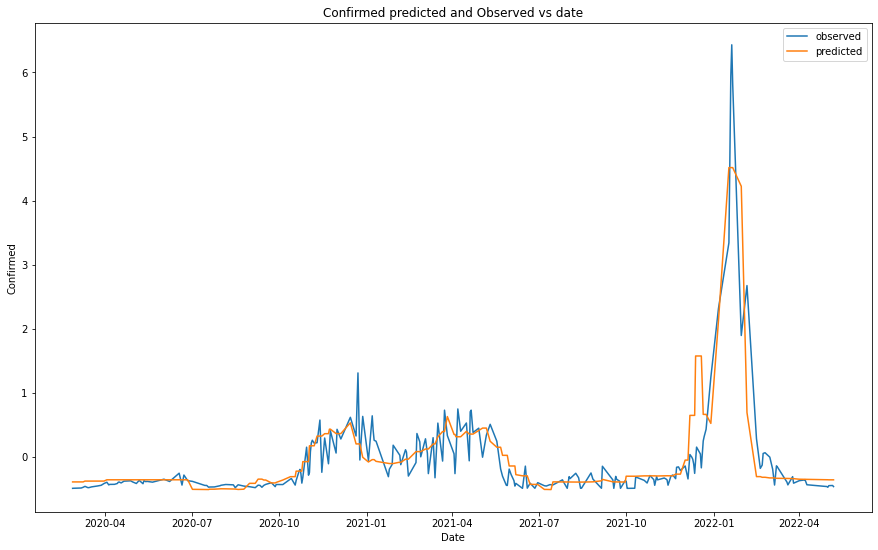

In [210]:
plot_date_observed_vs_predicted_confirmed(predicted);

In [211]:
reg = DecisionTreeRegressor(random_state=0) 
scores = defaultdict(list)

reg.fit(X_train, y_train.values.reshape(-1,1))

predicted = reg.predict(X_test)

print_stats(col_name, predicted, y_test)
pd.DataFrame(scores)

r2  max_error      rmse
0  0.807984    4.21382  0.136605

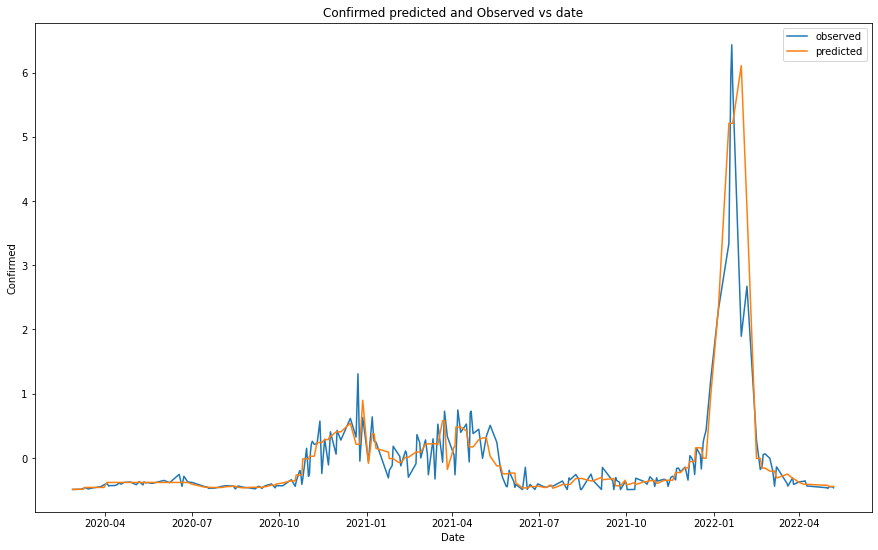

In [212]:
plot_date_observed_vs_predicted_confirmed(predicted);

## Predykcja zgonów

In [213]:
col_name = ['hosp', 'year', 'vaccines']

X_train, X_test, y_train, y_test = train_test_split(local_agg[col_name], local_agg['deaths'], test_size=0.30, random_state=0)


In [214]:
reg = RandomForestRegressor()
scores = defaultdict(list)

reg.fit(X_train, y_train)

predicted = reg.predict(X_test)

print_stats(col_name, predicted, y_test)
pd.DataFrame(scores)

r2  max_error      rmse
0  0.82799   2.298462  0.181302

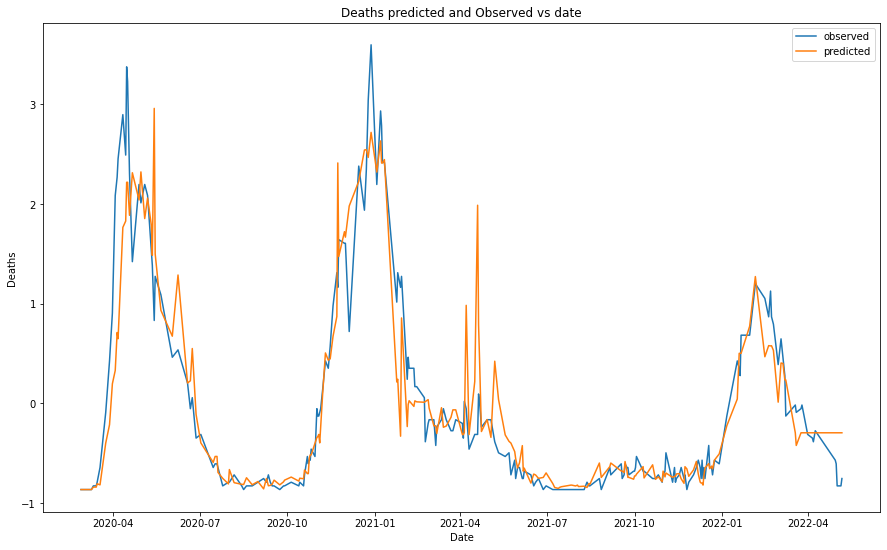

In [215]:
plot_date_observed_vs_predicted_deaths(predicted);

In [216]:
reg = SVR()
scores = defaultdict(list)

reg.fit(X_train, y_train)

predicted = reg.predict(X_test)

print_stats(col_name, predicted, y_test)
pd.DataFrame(scores)

r2  max_error      rmse
0  0.871089   1.477673  0.135875

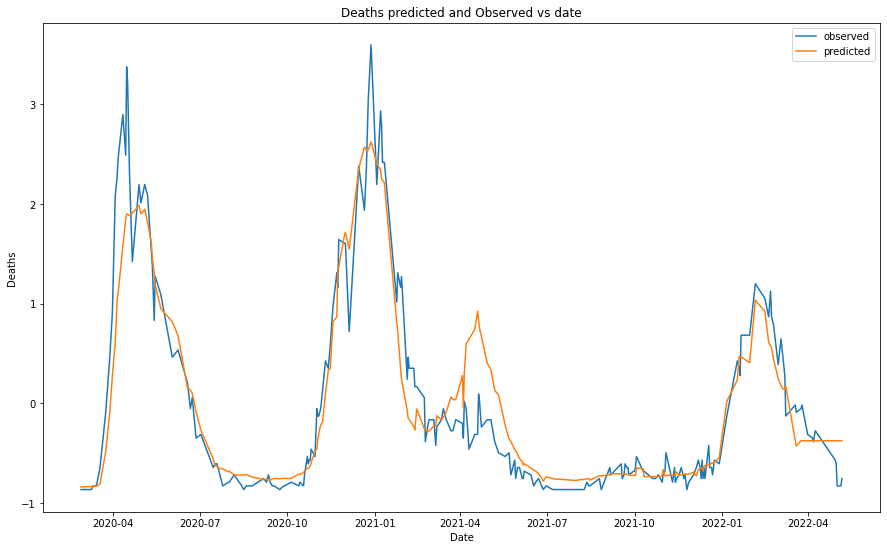

In [217]:
plot_date_observed_vs_predicted_deaths(predicted);

In [218]:
reg = DecisionTreeRegressor(random_state=0) 
scores = defaultdict(list)

reg.fit(X_train, y_train.values.reshape(-1,1))

predicted = reg.predict(X_test)

print_stats(col_name, predicted, y_test)
pd.DataFrame(scores)

r2  max_error      rmse
0  0.782428   2.691062  0.229325

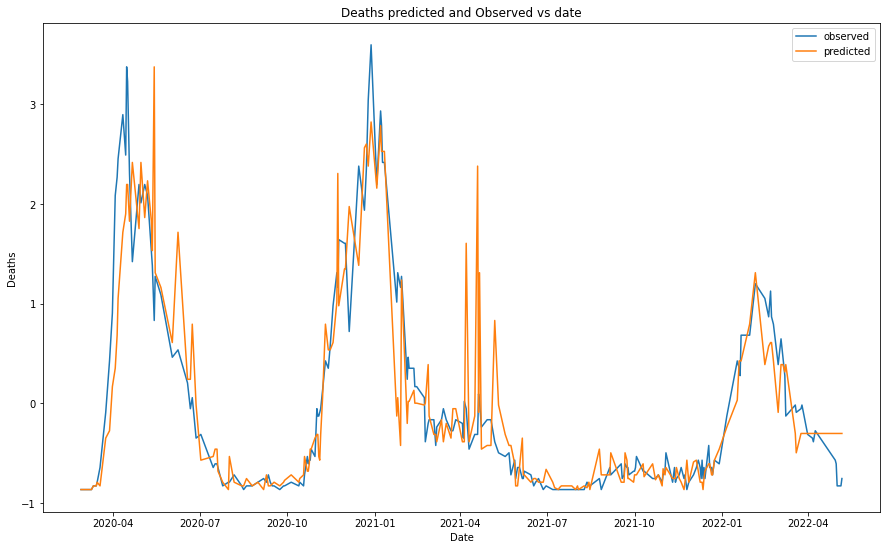

In [219]:
plot_date_observed_vs_predicted_deaths(predicted);

## Porównanie algorytmów

Można zauważyć, że algorytmy SVR, RadnomFOrest oraz DecisionTree daja o wiele lepsze wyniki  w porównaniu do regresji liniowej. 




#### Przypadki
W porównaniu do modelów liniowych tutaj każdy model daje dobry wynik na poziomie 76%-81%, bezwględu ktory zastosujemy efekt bedzie podobny. Przy czym RandomForest oraz DecisionTree lepiej wpasowuje sie w dane.

#### Smiertelnosc
Dla śmioertelnosci  najlepszymi modelem okazał się definitiwnie  model SVR z opisowoscia danych na poziomie 87% z bledem oraz rmse niższym niż w modelu regresji wielorakiej(1.5, 0.14). Rowniez patrzac na wykresy w algorytmach RandomForest oraz DecisionTree mozemy zauwayc pewne anomalia, ktore wystepuja na przelomie kwietnia/czerwca 2021.



#### Podsumowujac
Mozna wyknuc wniosek, ze nasze dane bardziej pasuja do nieliniowych algorytmow.

# Ogólne konkluzje

Podsumowajac, analiza predykcji ilosci przypadkow oraz smiertelnosci dla wirusa COVID-19, ktora zostala wykonana powyzej, ukazala, ze pomimo problemów z danymi, licznymi brakami udalo uzyskać się satysfakcjonujace wyniki przy uzyciu regresji liniowej. W obu przypadkach lepiej wychodzila predykcja smiertelnosci niz nowych przypadkow COVID-19(modele mialy wiecej zmiennych opisowych oraz spelnialy warunki regresji liniowej).Natomiast ciężko bylo znaleźć zmienne nieskorelowane ze soba, aby uniknąć multikorelacji, w modelach regresji wielorakiej dlatego uwazam, ze lepszym rozwiazaniem tego problemu jest zasotoswanie algorytmow nieliniowych, wytarczy tylko porownac wyniki regresji wielorakiej z innymi algorytmami. Dla kazdego algorytmu wynik byl znacznie lepszy. W celu ulepszenia wynikow moznaby bylo jeszcze zastosowac techniki analizy szeregow czasowych, np. usuniecie sezonowatosci z danych. Wyniki bylby jeszcze lepsze. W przypadku danych globalnych, wyniki byly mierne, spowodowane ze kraje z roznych zakątków inaczej podchodzily do wirusa oraz do publikowania danych na ten temat przez co ciezko tu o jakakolwiek predykcje, dlatego dane globalne zastąpiłem danymi z krajów Unii Europejskiej, poniewaz jest to spojna organizacja, gdzie podjescie do wirusa bylo podobne. W tym przypadku nie bylo juz problemow z danymi.</br>
Po wykonanej predykcji mozna zauwazyc, ze szczepienia na covida nie do konca zmniejszyly poziom zachorowan lub smiertelnosci, zmienna nie miala na to wplywu.



